### Plan of Action
🧠 Step-by-Step Pipeline: Generalized Model + EA + XGBoost
1. Data Preparation
- Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)
- Normalize features per ticker (z-score or min-max scaling)
- Add metadata: ticker_id, sector, day_of_week, macro regime (optional)
- Create rolling windows for time series modeling (e.g., 10-day sequences)
2. Feature Engineering
- Technical indicators: RSI, MACD, Bollinger Bands, ATR
- Candle features: range, body size, wick ratios
- Volume features: OBV, VWAP, volume spikes
- Lagged returns, volatility, momentum scores
3. Labeling Strategy
- Define swing trade targets:
- Binary: Will price rise >x% in next n days?
- Multi-class: Uptrend / Downtrend / Sideways
- Regression: Expected return over next n days

🧬 4. Evolutionary Algorithm Optimization
- Purpose: Explore feature combinations, thresholds, and model hyperparameters
- Approach:
- Use genetic algorithm (e.g., DEAP, PyGAD) to evolve:
- Feature subsets
- Thresholds for entry/exit
- XGBoost hyperparameters (e.g., depth, learning rate)
- Fitness function: Sharpe ratio, accuracy, precision, or custom KPI
# Example fitness function
def fitness(individual):
    selected_features = individual[:n]
    xgb_params = decode_params(individual[n:])
    model = XGBClassifier(**xgb_params)
    score = cross_val_score(model, X[selected_features], y, scoring='accuracy')
    return score.mean(),



🌲 5. XGBoost Refinement
- Train final model using best EA-selected features and hyperparameters
- Use XGBoost for:
- Feature importance ranking
- Fast inference
- Robust performance on tabular data
from xgboost import XGBClassifier
model = XGBClassifier(**best_params)
model.fit(X_train[selected_features], y_train)



📊 6. Evaluation & Backtesting
- Use walk-forward validation or time-series cross-validation
- Evaluate:
- Accuracy, precision, recall
- Sharpe ratio, Sortino ratio
- Win rate, average trade duration


# 0. Dependencies

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

## 1. Data Preparation
### Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)

Core Equity Holdings (NN Group, 2025)
- "AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK"

ETF Additions (for sector/macro exposure)
- "SPY", "TLT", "LQD", "VNQ", "XLV"


Description:
- Amazon.com Inc – Consumer Discretionary
- Meta Platforms Inc – Communication Services
- Broadcom Inc – Technology
- Eli Lilly & Co – Healthcare
- Eaton Corp PLC – Industrials
- CyberArk Software Ltd – Technology
- Linde PLC – Materials
- Waste Management Inc – Industrials
- Soleno Therapeutics Inc – Healthcare
- Cytokinetics Inc – Healthcare
- SPDR S&P 500 ETF (SPY) – Broad Market ETF
- iShares 20+ Year Treasury ETF (TLT) – Government Bonds
- iShares Investment Grade Corporate Bond ETF (LQD) – Corporate Bonds
- Vanguard Real Estate ETF (VNQ) – Real Estate
- Health Care Select Sector SPDR ETF (XLV) – Healthcare Sector ETF

Based on Q2 2025 of Nationale-Nederlanden Powszechne Towarzystwo Emerytalne S.A.
https://www.sensamarket.com/institutional-investor/000201108125000008/compare/000201108125000005

In [2]:
tickers = ["AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK", "SPY", "TLT", "LQD", "VNQ", "XLV"]
leadup_days = 70
start_date = (datetime.strptime("2015-01-01", "%Y-%m-%d") - timedelta(days=leadup_days)).strftime("%Y-%m-%d")
raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")

C:\Users\DLinger\AppData\Local\Temp\ipykernel_6020\742186514.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")
[*********************100%***********************]  15 of 15 completed


In [3]:
raw_data

Ticker           CYTK                                                  AMZN  \
Price            Open       High        Low      Close   Volume        Open   
Date                                                                          
2014-10-23   3.370000   3.540000   3.310000   3.450000   179600   15.670000   
2014-10-24   3.460000   3.500000   3.370000   3.500000   119700   14.220000   
2014-10-27   3.510000   3.510000   3.300000   3.430000   176100   14.285000   
2014-10-28   3.460000   3.590000   3.400000   3.570000   224900   14.488000   
2014-10-29   3.590000   3.730000   3.450000   3.650000   314700   14.955500   
...               ...        ...        ...        ...      ...         ...   
2024-12-24  48.849998  49.110001  48.000000  48.529999   319000  226.940002   
2024-12-26  48.139999  48.950001  47.990002  48.540001   942100  228.500000   
2024-12-27  48.130001  48.849998  47.220001  47.360001   902000  225.600006   
2024-12-30  47.000000  47.790001  46.520000  47.150002  1043200  220.059998   
2024-12-31  47.500000  47.779999  46.799999  47.040001   797900  222.970001   

Ticker                                                     ...         LLY  \
Price             High         Low       Close     Volume  ...        Open   
Date                                                       ...               
2014-10-23   15.840000   15.570000   15.659000  180764000  ...   52.422729   
2014-10-24   14.690500   14.200000   14.353000  396022000  ...   52.675610   
2014-10-27   14.521000   14.251000   14.498500  119012000  ...   53.784907   
2014-10-28   14.900000   14.488000   14.779500  111452000  ...   53.833850   
2014-10-29   14.980500   14.653500   14.706000   97638000  ...   53.018196   
...                ...         ...         ...        ...  ...         ...   
2024-12-24  229.139999  226.130005  229.050003   15007500  ...  786.664605   
2024-12-26  228.500000  226.669998  227.050003   16146700  ...  789.398251   
2024-12-27  226.029999  220.899994  223.750000   27367100  ...  785.302773   
2024-12-30  223.000000  218.429993  221.300003   28321200  ...  773.294528   
2024-12-31  223.229996  218.940002  219.389999   24819700  ...  766.415736   

Ticker                                                          SPY  \
Price             High         Low       Close   Volume        Open   
Date                                                                  
2014-10-23   53.181297   52.023055   52.487984  6343000  161.200799   
2014-10-24   54.029610   52.528790   53.874638  4784700  161.722612   
2014-10-27   54.339559   53.662556   53.996975  4112500  162.120226   
2014-10-28   53.915415   51.990450   52.879524  8981000  163.023042   
2014-10-29   53.809391   52.838748   53.417870  6196800  164.455924   
...                ...         ...         ...      ...         ...   
2024-12-24  793.006675  782.419975  790.939026  1165400  590.882491   
2024-12-26  799.130019  786.793834  789.418152  1274200  594.292655   
2024-12-27  788.583140  774.586841  778.513367  2096500  592.349606   
2024-12-30  775.123614  766.415690  769.238831  1719100  582.783506   
2024-12-31  769.308407  759.755561  767.409790  2327000  584.785824   

Ticker                                                     
Price             High         Low       Close     Volume  
Date                                                       
2014-10-23  162.509491  160.902616  161.457565  154944000  
2014-10-24  162.749689  161.093120  162.699982  117927000  
2014-10-27  162.716592  161.540429  162.476395   82954000  
2014-10-28  164.348290  162.948486  164.340012  106736000  
2014-10-29  164.928039  163.006426  164.091476  142557000  
...                ...         ...         ...        ...  
2024-12-24  596.116657  590.297589  596.076965   33160100  
2024-12-26  597.246751  592.885006  596.116699   41219100  
2024-12-27  592.587572  585.628530  589.841614   64969300  
2024-12-30  586.600040  579.333692  583.110596   56578800  
2024-12-31  585.509524  5

## Technical Indicators
Momentum 
- RSI
- StochRSI

Trend
- MACD
- SMA
- EMA

Volatility
- BB (Bollinger Bands)
- ATR (Average True Range)

Volume
- OBV (On-Balance Volume)
- CMF (Chaikin Money Flow)

In [4]:
def add_features(df):
    df = df.copy()
    
    # General price dynamics
    df["returns"] = df["Close"].pct_change()
    df["logReturns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["returns"].rolling(10).std()
    df['Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Wick'] = df['Range'] - df['Body']

    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['StochRSI'] = StochRSIIndicator(df['Close'], window=14).stochrsi()
    
    # Short-term moving averages (faster response)
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Medium-term moving averages (faster than previous 50)
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()

    # Optional: slightly faster “long-term” averages for crossovers
    df['SMA_30'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['EMA_30'] = EMAIndicator(df['Close'], window=30).ema_indicator()

    # Faster MACD for earlier crossovers
    macd = MACD(df['Close'], window_slow=13, window_fast=6, window_sign=5)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['OBV_prev'] = pd.to_numeric(df['OBV'].shift(1), errors='coerce').fillna(0).astype(int)
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=20).chaikin_money_flow()
    
    # Future return (5-day horizon)
    df['future_close'] = df.groupby('Ticker')['Close'].shift(-5)
    df['future_return'] = df['future_close'] / df['Close'] - 1
    df.drop(columns='future_close', inplace=True)
    
    return df

In [5]:
df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])
df_long

C:\Users\DLinger\AppData\Local\Temp\ipykernel_6020\670735667.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = raw_data.stack(level=0).rename_axis(['Date', 'Ticker'])


Price                    Open        High         Low       Close       Volume
Date       Ticker                                                             
2014-10-23 AMZN     15.670000   15.840000   15.570000   15.659000  180764000.0
           AVGO      6.193995    6.251306    6.117080    6.136685   18205000.0
           CYBR     28.730000   29.500000   28.350000   29.209999     534000.0
           CYTK      3.370000    3.540000    3.310000    3.450000     179600.0
           ETN      47.507391   48.272651   47.384946   48.012463    3428900.0
...                       ...         ...         ...         ...          ...
2024-12-31 SPY     584.785824  585.509524  579.343521  580.989136   57052700.0
           TLT      85.312791   85.457997   84.470606   84.538368   31917300.0
           VNQ      86.383523   86.694220   85.713580   86.490326    5045100.0
           WM      200.272113  200.331460  198.679590  199.599487    1549000.0
           XLV     135.777671  136.310590  134.998011  135.767807    6626900.0

[38445 rows x 5 columns]

In [6]:
results = []
for ticker, df_t in df_long.groupby('Ticker'):
    df_t = add_features(df_t.copy())
    results.append(df_t)

# Step 1: Concatenate and sort
df_processed = pd.concat(results).sort_values(['Date', 'Ticker']).copy()
df_processed = df_processed.reorder_levels(['Date', 'Ticker']).sort_index()

# Step 2: Identify last 5 rows per ticker BEFORE dropping NaNs
last_5_mask = df_processed.groupby('Ticker').tail(5).index

# Step 3: Drop NaNs EXCEPT for those in last 5 rows
df_cleaned = df_processed[~df_processed.index.isin(last_5_mask)].dropna()
df_preserved = df_processed.loc[last_5_mask]  

# Step 4: Combine and sort
df_processed = pd.concat([df_cleaned, df_preserved]).sort_index()


df_processed.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')

In [7]:
# show a sample of each ticker
df_processed.groupby("Ticker").head(6)

Price                    Open        High         Low       Close      Volume  \
Date       Ticker                                                               
2014-12-04 AMZN     15.776500   15.929500   15.673500   15.846500  65806000.0   
           AVGO      7.657663    7.825823    7.503832    7.772284  61855000.0   
           CYBR     42.709999   43.090000   40.230000   40.599998    882600.0   
           CYTK      4.610000    4.770000    4.520000    4.560000    289100.0   
           ETN      53.761861   53.838938   53.122112   53.553753   1765500.0   
...                       ...         ...         ...         ...         ...   
2014-12-29 SLNO     99.750000  129.000000   99.750000  129.000000        64.0   
2014-12-30 SLNO     99.000000  123.000000   99.000000  112.500000       293.0   
2014-12-31 SLNO    123.750000  123.750000  106.500000  111.900002       275.0   
2015-01-02 SLNO    108.000000  121.800003  108.000000  112.500000        19.0   
2015-01-05 SLNO    117.000000  131.250000  117.000000  119.849998       137.0   

Price               returns  logReturns  Volatility      Range       Body  \
Date       Ticker                                                           
2014-12-04 AMZN    0.001359    0.001358    0.017462   0.256000   0.070001   
           AVGO    0.083465    0.080164    0.029183   0.321991   0.114620   
           CYBR   -0.056253   -0.057897    0.059312   2.860001   2.110001   
           CYTK   -0.015119   -0.015234    0.031661   0.250000   0.050000   
           ETN    -0.010397   -0.010452    0.014456   0.716825   0.208108   
...                     ...         ...         ...        ...        ...   
2014-12-29 SLNO    0.023810    0.023530    0.076803  29.250000  29.250000   
2014-12-30 SLNO   -0.127907   -0.136859    0.081580  24.000000  13.500000   
2014-12-31 SLNO   -0.005333   -0.005348    0.079998  17.250000  11.849998   
2015-01-02 SLNO    0.005362    0.005348    0.049637  13.800003   4.500000   
2015-01-05 SLNO    0.065333    0.063288    0.054956  14.250000   2.849998   

Price              ...      EMA_30       MACD  MACD_Signal     BB_High  \
Date       Ticker  ...                                                   
2014-12-04 AMZN    ...   15.971785  -0.032485     0.108201   17.265272   
           AVGO    ...    6.741108   0.210140     0.142136    7.412589   
           CYBR    ...   38.609623   0.314067     0.721669   48.695974   
           CYTK    ...    4.193383   0.113481     0.120165    4.725520   
           ETN     ...   51.789582   0.410057     0.345682   54.094194   
...                ...         ...        ...          ...         ...   
2014-12-29 SLNO    ...  189.615115 -18.379792   -22.212519  249.463134   
2014-12-30 SLNO    ...  184.639947 -18.199070   -20.874702  236.036051   
2014-12-31 SLNO    ...  179.947047 -17.431319   -19.726908  229.220777   
2015-01-02 SLNO    ...  175.595625 -16.164071   -18.539295  226.250346   
2015-01-05 SLNO    ...  171.999133 -13.678447   -16.919013  221.170625   

Price                 BB_Low        ATR          OBV   OBV_prev       CMF  \
Date       Ticker                                                           
2014-12-04 AMZN    14.913478   0.388233  593718000.0  527912000  0.145854   
           AVGO     6.224155   0.215304  284248000.0  222393000  0.280988   
           CYBR    32.001025   2.964049   11467400.0   12350000  0.205174   
           CYTK     3.977480   0.265246    2549700.0    2838800 -0.058999   
           ETN     50.977945   0.939440   35417700.0   37183200  0.290658   
...                      ...        ...          ...        ...       ...   
2014-12-29 SLNO    88.666867  26.888375       9153.0       9089 -0.445472   
2014-12-30 SLNO    87.993950  27.110634       8860.0       9153 -0.423941   
2014-12-31 SLNO    84.249223  26.406303       8585.0       8860 -0.418433   
2015-01-02 SLNO    79.569654  25.505853       8604.0       8585 -0.416766   
2015-01-05 SLNO    77.134375  25.023292       8741.0     

I need to label a dataset programmatically and for this I will use a rule-base. For example for the MACD if it is above the signal line you're supposed to buy while when it dips below you should sell. I want to generate training labels (Buy / Sell / Hold) based on a rule base of technical indicators, so the neural network can later learn to mimic or improve upon those heuristics.

1. defining the labeling Goal
    -   1 → Buy signal
    -  -1 → Sell signal
    -   0 → Hold / Neutral

2. based on this rich feature set:
['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick',
 'RSI', 'StochRSI', 'SMA_20', 'EMA_20', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF']

    We can use a combination of these for rule-based labeling.

3. 

Since the literature suggests some support but also many limitations, the weighting scheme should reflect:
Medium-to-moderate weights for indicators that have some empirical backing (e.g., volume-based, RSI) but are not perfect.
Lower weights for indicators that are more lagging, less studied, or have weaker evidence (e.g., simple moving averages of longer lengths without context).
Higher weights only if we back-test the specific asset/timeframe and show a strong statistical edge.


In [8]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def label_data(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # SMA trend signals
    votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # SMA crossover (short vs medium)
    votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels if needed for EA
    df['label'] = np.sign(prelim_label)
    
    # --- Realign labels based on actual future return polarity ---
    # df['label'] = np.where((df['label'] == -1) & (df['future_return'] > 0), 0, df['label'])
    # df['label'] = np.where((df['label'] == 1) & (df['future_return'] < 0), 0, df['label'])

    df['vote_total'] = votes
    return df

In [9]:
""" | Indicator(s)             | Rule                                                                            | Label |
    | ------------------------ | ------------------------------------------------------------------------------- | ----- |
    | MACD & MACD_Signal       | If `MACD > MACD_Signal` → **Buy**, if `MACD < MACD_Signal` → **Sell**           | ±1    |
    | RSI                      | If `RSI < 30` → **Buy** (oversold), if `RSI > 70` → **Sell** (overbought)       | ±1    |
    | StochRSI                 | If `StochRSI < 0.2` → **Buy**, if `StochRSI > 0.8` → **Sell**                   | ±1    |
    | SMA / EMA                | If `Close > SMA_20` → **Buy**, if `Close < SMA_20` → **Sell**                   | ±1    |
    | Bollinger Bands          | If `Close < BB_Low` → **Buy**, if `Close > BB_High` → **Sell**                  | ±1    |
    | OBV (On-Balance Volume)  | If `OBV > OBV_prev` → **Buy**, if `OBV < OBV_prev` → **Sell**                   | ±1    |
    | CMF (Chaikin Money Flow) | If `CMF > 0` → **Buy**, if `CMF < 0` → **Sell**                                 | ±1    |
    | Volatility / ATR         | If `Volatility` or `ATR` is high, reduce conviction (set to `0` to avoid noise) | 0     |
"""

def label_data_adjusted(df):
    df = df.copy()

    # Initialize vote counter
    votes = np.zeros(len(df), dtype=float)

    # ---- Weighted voting system ----
    # Stronger weights = more historically reliable / consistent indicator
    w = {
        # Core momentum/trend indicators
        'MACD': 1.0,
        'RSI': 0.8,
        'StochRSI': 0.6,

        # Short / medium / long-term trend indicators
        'SMA_10': 0.9,           # Short-term trend
        'SMA_20': 1.0,           # Medium-term trend
        'SMA_30': 1.1,           # Long-term anchor
        'SMA_cross': 1.0,        # 10 vs 20 crossover
        'SMA_long_cross': 1.0,   # 20 vs 30 crossover

        'EMA_10': 0.9,
        'EMA_20': 1.0,
        'EMA_30': 1.1,
        'EMA_cross': 1.0,
        'EMA_long_cross': 1.0,

        # Volatility and confirmation indicators
        'BB': 0.75,
        'OBV': 0.9,
        'CMF': 0.8,
        'Body': 0.6,
        'Wick': 0.8,
        'Volatility': 0.4,
    }

    # --- Apply rules ---
     # Shift indicators by 1 bar to avoid lookahead
    df_shift = df.shift(1)

    # --- Apply rules with shifted indicators ---
    
    # MACD crossover
    votes += w['MACD'] * np.where(df_shift['MACD'] > df_shift['MACD_Signal'], 1, 
                                  np.where(df_shift['MACD'] < df_shift['MACD_Signal'], -1, 0))
    
    # RSI thresholds
    votes += w['RSI'] * np.where(df_shift['RSI'] < 30, 1, 
                                 np.where(df_shift['RSI'] > 70, -1, 0))
    
    # StochRSI thresholds
    votes += w['StochRSI'] * np.where(df_shift['StochRSI'] < 0.2, 1, 
                                      np.where(df_shift['StochRSI'] > 0.8, -1, 0))
    
    # RSI divergence (optional)
    rsi_div = (df_shift['RSI'] > df_shift['RSI'].shift(1)) & (df_shift['Close'] < df_shift['Close'].shift(1))
    votes += 0.6 * np.where(rsi_div, -1, 0)
    
    # --- Short-term and medium-term trend signals ---

    # SMA trend signals
    votes += w['SMA_10'] * np.where(df_shift['Close'] > df_shift['SMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_10'], -1, 0))
    votes += w['SMA_20'] * np.where(df_shift['Close'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_20'], -1, 0))

    # SMA crossover (short vs medium)
    votes += w['SMA_cross'] * np.where(df_shift['SMA_10'] > df_shift['SMA_20'], 1,
                                    np.where(df_shift['SMA_10'] < df_shift['SMA_20'], -1, 0))

    # EMA trend signals
    votes += w['EMA_10'] * np.where(df_shift['Close'] > df_shift['EMA_10'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_10'], -1, 0))
    votes += w['EMA_20'] * np.where(df_shift['Close'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_20'], -1, 0))

    # EMA crossover (short vs medium)
    votes += w['EMA_cross'] * np.where(df_shift['EMA_10'] > df_shift['EMA_20'], 1,
                                    np.where(df_shift['EMA_10'] < df_shift['EMA_20'], -1, 0))

    # Optional: long-term trend anchors
    votes += w['SMA_30'] * np.where(df_shift['Close'] > df_shift['SMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_30'] * np.where(df_shift['Close'] > df_shift['EMA_30'], 1,
                                    np.where(df_shift['Close'] < df_shift['EMA_30'], -1, 0))
    
    # Long-term crossover (medium vs long)
    votes += w['SMA_long_cross'] * np.where(df_shift['SMA_20'] > df_shift['SMA_30'], 1,
                                            np.where(df_shift['SMA_20'] < df_shift['SMA_30'], -1, 0))
    votes += w['EMA_long_cross'] * np.where(df_shift['EMA_20'] > df_shift['EMA_30'], 1,
                                            np.where(df_shift['EMA_20'] < df_shift['EMA_30'], -1, 0))
    
    # Bollinger Bonds breakout
    votes += w['BB'] * np.where(df_shift['Close'] < df_shift['BB_Low'], 1, 
                                np.where(df_shift['Close'] > df_shift['BB_High'], -1, 0))
    
    # OBV momentum
    votes += w['OBV'] * np.where(df_shift['OBV'] > df_shift['OBV_prev'], 1, 
                                 np.where(df_shift['OBV'] < df_shift['OBV_prev'], -1, 0))
    
    # CNF accumulation/distribution
    votes += w['CMF'] * np.where(df_shift['CMF'] > 0, 1, np.where(df_shift['CMF'] < 0, -1, 0))

    # Candle body momentum
    body_avg = df_shift['Body'].rolling(5, min_periods=1).mean()
    votes += w['Body'] * np.where(df_shift['Body'] > body_avg, 1, np.where(df_shift['Body'] < body_avg, -1, 0))

    # Wick exhaustion
    votes += w['Wick'] * np.where(df_shift['Wick'] > df_shift['Range'] * 0.6, -1, 
                                  np.where(df_shift['Wick'] < df_shift['Range'] * 0.1, 1, 0))
    
    # Bearish engulfing candle
    bear_engulf = (df_shift['Open'] < df_shift['Close']) & (df_shift['Close'] < df_shift['Open'].shift(1)) & (df_shift['Open'] > df_shift['Close'].shift(1))
    votes += 0.8 * np.where(bear_engulf, -1, 0)


    # Volatility contraction
    vol_avg = df_shift['Volatility'].rolling(10, min_periods=1).mean()
    votes += w['Volatility'] * np.where(df_shift['Volatility'] < vol_avg, 1, 0)

    # --- Targeted volatility soft gate ---
    atr_mean = df_shift['ATR'].rolling(50, min_periods=10).mean()
    atr_std = df_shift['ATR'].rolling(50, min_periods=10).std()
    high_atr = df_shift['ATR'] > (atr_mean + 2 * atr_std)

    scale = np.ones(len(df))
    scale[high_atr] = np.clip((atr_mean[high_atr] + 2 * atr_std[high_atr]) / df_shift['ATR'][high_atr], 0.3, 1.0)
    votes *= scale

    # --- Preliminary label ---
    prelim_label = np.where(votes > 4, 1, np.where(votes < -4, -1, 0))

    # --- Soft fallback logic for weak votes ---
    fallback_zone = (prelim_label == 0) & (np.abs(votes) <= 2)
    soft_vote_strength = 0.5
    low_vol = df_shift['ATR'] < atr_mean
    fallback_bear = (df_shift['EMA_10'] < df_shift['EMA_20']) & fallback_zone & low_vol
    fallback_bull = (df_shift['EMA_10'] > df_shift['EMA_20']) & fallback_zone & low_vol

    prelim_label[fallback_bull] = soft_vote_strength
    prelim_label[fallback_bear] = -soft_vote_strength


    # Convert soft votes to discrete labels if needed for EA
    df['label'] = np.sign(prelim_label)
    
    # --- Realign labels based on actual future return polarity ---
    df['label'] = np.where((df['label'] == -1) & (df['future_return'] > 0), 0, df['label'])
    df['label'] = np.where((df['label'] == 1) & (df['future_return'] < 0), 0, df['label'])

    df['vote_total'] = votes
    return df

In [10]:
print(df_processed.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return'],
      dtype='object', name='Price')


In [11]:
df_labeled = label_data(df_processed)
df_labeled.head(5)

Price                   Open       High        Low      Close      Volume  \
Date       Ticker                                                           
2014-12-04 AMZN    15.776500  15.929500  15.673500  15.846500  65806000.0   
           AVGO     7.657663   7.825823   7.503832   7.772284  61855000.0   
           CYBR    42.709999  43.090000  40.230000  40.599998    882600.0   
           CYTK     4.610000   4.770000   4.520000   4.560000    289100.0   
           ETN     53.761861  53.838938  53.122112  53.553753   1765500.0   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Date       Ticker                                                        ...   
2014-12-04 AMZN    0.001359    0.001358    0.017462  0.256000  0.070001  ...   
           AVGO    0.083465    0.080164    0.029183  0.321991  0.114620  ...   
           CYBR   -0.056253   -0.057897    0.059312  2.860001  2.110001  ...   
           CYTK   -0.015119   -0.015234    0.031661  0.250000  0.050000  ...   
           ETN    -0.010397   -0.010452    0.014456  0.716825  0.208108  ...   

Price              MACD_Signal    BB_High     BB_Low       ATR          OBV  \
Date       Ticker                                                             
2014-12-04 AMZN       0.108201  17.265272  14.913478  0.388233  593718000.0   
           AVGO       0.142136   7.412589   6.224155  0.215304  284248000.0   
           CYBR       0.721669  48.695974  32.001025  2.964049   11467400.0   
           CYTK       0.120165   4.725520   3.977480  0.265246    2549700.0   
           ETN        0.345682  54.094194  50.977945  0.939440   35417700.0   

Price               OBV_prev       CMF  future_return  label  vote_total  
Date       Ticker                                                         
2014-12-04 AMZN    527912000  0.145854      -0.030196      0        0.00  
           AVGO    222393000  0.280988      -0.024450      0        0.70  
           CYBR     12350000  0.205174      -0.067734      1        9.75  
           CYTK      2838800 -0.058999       0.061404      1        6.50  
           ETN      37183200  0.290658      -0.038141      1        5.70  

[5 rows x 30 columns]

#### Analyzing label quality

In [12]:
# check label distribution
df_labeled["label"].value_counts(normalize=True)

label
 1    0.513944
-1    0.318600
 0    0.167456
Name: proportion, dtype: float64

In [13]:
# check label seperability
# forward_return = future n-bar return, e.g. close.shift(-5)/close - 1
df_labeled.groupby('label')['future_return'].mean()

label
-1    0.005199
 0    0.005257
 1    0.004549
Name: future_return, dtype: float64

<Axes: xlabel='label', ylabel='future_return'>

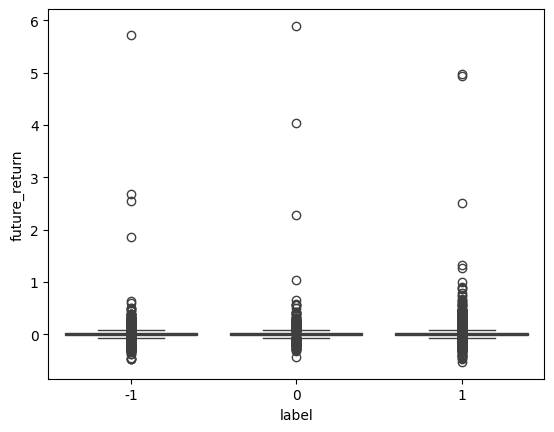

In [14]:
# verify direction
sns.boxplot(data=df_labeled, x='label', y='future_return')


That’s a very healthy label distribution — nearly balanced, with only a mild bullish skew.

Let’s interpret it precisely:

Label	Meaning	Proportion	Comment
+1	Bullish (buy signal)	40.1%	Slightly dominant — suggests the rule set tends to favor upward conditions (typical for equities and trending assets).
0	Neutral / no clear signal	30.2%	Good — not overfitting noise. Roughly one-third of the time the system abstains from making a call, which usually improves robustness.
–1	Bearish (sell signal)	29.7%	Almost symmetric with +1 — nice balance.

In [15]:
df_labeled.groupby('label')['future_return'].mean()
df_labeled.groupby("Ticker").tail(1)

Price                    Open        High         Low       Close      Volume  \
Date       Ticker                                                               
2024-12-31 AMZN    222.970001  223.229996  218.940002  219.389999  24819700.0   
           AVGO    234.214889  235.783737  229.677142  230.203400  17927700.0   
           CYBR    320.790009  336.839996  315.260010  333.149994    931700.0   
           CYTK     47.500000   47.779999   46.799999   47.040001    797900.0   
           ETN     328.930896  330.643625  327.950796  328.554688   1134600.0   
           LIN     414.569519  416.055040  411.737138  414.628967   1386700.0   
           LLY     766.415736  769.308407  759.755561  767.409790   2327000.0   
           LQD     103.718188  103.814858  103.118826  103.283165  10768700.0   
           META    590.889764  592.585753  582.489342  584.145508   6019500.0   
           SLNO     45.529999   46.000000   43.860001   44.950001    910800.0   
           SPY     584.785824  585.509524  579.343521  580.989136  57052700.0   
           TLT      85.312791   85.457997   84.470606   84.538368  31917300.0   
           VNQ      86.383523   86.694220   85.713580   86.490326   5045100.0   
           WM      200.272113  200.331460  198.679590  199.599487   1549000.0   
           XLV     135.777671  136.310590  134.998011  135.767807   6626900.0   

Price               returns  logReturns  Volatility      Range       Body  \
Date       Ticker                                                           
2024-12-31 AMZN   -0.008631   -0.008668    0.017768   4.289993   3.580002   
           AVGO   -0.015876   -0.016003    0.036937   6.106595   4.011489   
           CYBR    0.042397    0.041523    0.022585  21.579987  12.359985   
           CYTK   -0.002333   -0.002336    0.021620   0.980000   0.459999   
           ETN    -0.001534   -0.001535    0.014042   2.692829   0.376209   
           LIN     0.002418    0.002415    0.009129   4.317902   0.059449   
           LLY    -0.002378   -0.002381    0.016006   9.552846   0.994054   
           LQD    -0.002521   -0.002524    0.005135   0.696032   0.435023   
           META   -0.009691   -0.009739    0.016484  10.096411   6.744256   
           SLNO   -0.007726   -0.007756    0.028455   2.139999   0.579998   
           SPY    -0.003638   -0.003645    0.012335   6.166003   3.796688   
           TLT    -0.005353   -0.005367    0.008120   0.987391   0.774422   
           VNQ     0.008719    0.008682    0.016242   0.980640   0.106803   
           WM     -0.002373   -0.002376    0.007375   1.651870   0.672626   
           XLV     0.002404    0.002402    0.008788   1.312578   0.009864   

Price              ...  MACD_Signal     BB_High      BB_Low        ATR  \
Date       Ticker  ...                                                   
2024-12-31 AMZN    ...     0.762264  234.204482  215.336517   5.155421   
           AVGO    ...    11.722169  267.752237  149.303594  10.671310   
           CYBR    ...     1.181573  332.372133  308.240862  10.233145   
           CYTK    ...    -0.601646   52.091683   45.937318   1.723680   
           ETN     ...    -6.298345  377.333351  317.856749   6.901218   
           LIN     ...    -5.393362  455.098274  403.900786   6.174015   
           LLY     ...    -2.390424  827.085318  746.391995  20.193389   
           LQD     ...    -0.484244  107.333397  102.032345   0.630990   
           META    ...    -2.354599  634.994548  580.321180  14.786446   
           SLNO    ...    -1.024036   50.852139   43.061860   2.302467   
           SPY     ...    -1.506478  607.509050  578.547817   6.719264   
           TLT     ...    -0.930845   91.986203   82.609501   0.975995   
           VNQ     ...    -1.136732   94.239479   83.504999   1.313208   
           WM      ...    -3.331439  224.181722  194.198043   2.964076   
           XLV     ...    -0.985493  144.701931  132.466770   1.675719   

Price                       OBV     OBV_prev       CM

In [16]:
df_labeled.columns.name = "Features"
print(df_labeled.columns)



Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'label', 'vote_total'],
      dtype='object', name='Features')


In [17]:

def backtest_vs_market(df, label_col="label", return_col="returns", ticker_col="Ticker", date_col="Date"):
    """
    Backtests strategy per ticker and compares it to actual market performance.
    Prints a summary and generates a separate plot for each ticker.
    """
    df_copy = df.reset_index().copy()
    df_copy.sort_values([ticker_col, date_col], inplace=True)

    tickers = df_copy[ticker_col].unique()

    for ticker in tickers:
        df_t = df_copy[df_copy[ticker_col] == ticker].copy()

        # Strategy logic
        df_t["position"] = df_t[label_col].shift(1)
        df_t["strategy_returns"] = df_t["position"] * df_t[return_col]
        df_t["strategy_returns"] = df_t["strategy_returns"].fillna(0)
        df_t['strategy_returns'].plot(title=f"Strategy Returns – {ticker}")
        


        # Cumulative returns
        df_t["cumulative_market"] = (1 + df_t[return_col]).cumprod()
        df_t["cumulative_strategy"] = (1 + df_t["strategy_returns"]).cumprod()

        # Metrics
        strategy_return = df_t["cumulative_strategy"].iloc[-1] - 1
        market_return = df_t["cumulative_market"].iloc[-1] - 1
        hit_rate = (df_t["strategy_returns"] > 0).mean()

        # Print summary
        print(f"\n📈 Ticker: {ticker}")
        print(f"Strategy Total Return: {strategy_return:.2%}")
        print(f"Market Total Return:   {market_return:.2%}")
        print(f"Hit Rate:              {hit_rate:.2%}")
        
        # print(f"\n{ticker} – Last 5 strategy returns:")
        # print(df_t[['Date', 'label', 'position', 'strategy_returns']].tail())
        # print(df_t[['ATR', 'label']].tail(10))


        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df_t[date_col], df_t["cumulative_market"], linestyle="--", label="Market", color="gray")
        plt.plot(df_t[date_col], df_t["cumulative_strategy"], label="Strategy", color="blue")
        plt.title(f"Cumulative Returns – {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [18]:
# backtest_vs_market(df_labeled)

### Issues
1. Signal flatlining examples

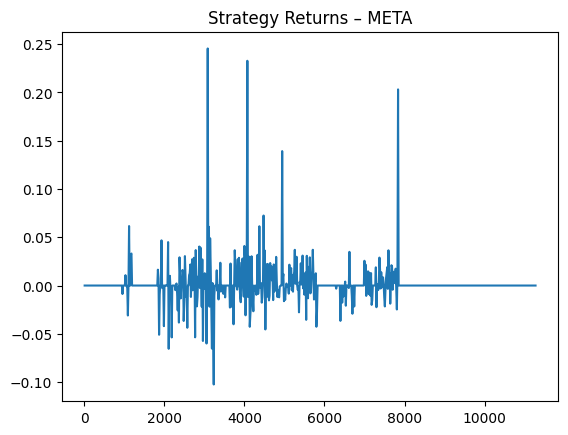

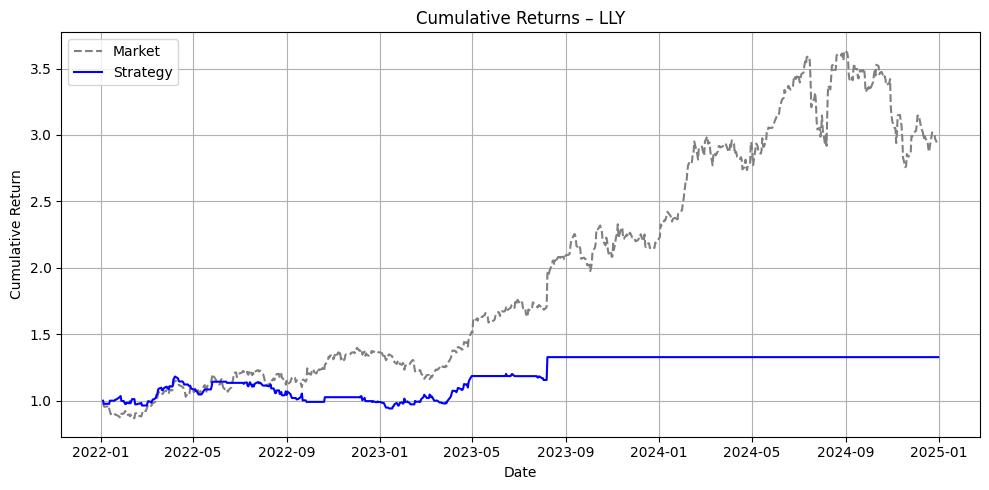


This was not a computational bug, but a signal silence issue. When the rulebase is voting neutral for consecutive days the strategy is deliberately abstaining from trading. Not inherently bad but could mean the volatility filter is overly active, votethreshold too strict or potentially indicators are cancelling eachother out. Further diagnostics revealed that the volatiliy gating logic is suppressing signals during periods of elevated ATR, causing a persistent label==0 and flatlining of strategy returns. 

(  # Volatility filter (neutralize extreme noise)
    high_vol = df['ATR'] > df['ATR'].quantile(0.9))

This logic means that any time ATR exceeds the 90th percentile, we force the label to 0 regardless of vote strength. This is a hard gate — and while it protects against noise, it can also suppress valid signals during high-volatility breakouts. Hard gating these events in the labeled data will prevent the model from learning how to trade in all types of regimes including volatile ones. This in turn will cause the model to underperform in real-time if volatility spikes and no fallback logic is present.

this is a real issue in indicator ensemble systems: volatility filters (like ATR > 90th percentile) are great for preventing false breakouts, but they can “hard-freeze” the model in prolonged volatile regimes (like macro shocks or crypto rallies), causing the signal to flatline to 0 when the system should actually be adaptive.

Solution -> Soft gating mechanism: Instead of forcing the label to 0 if High_vol is True we scale down the vote intensity based on how high the volatitility is, allowing the model to stay cautiously responsive. 

2. Poor directional Separability
label
- -1    -> 0.011829 # supposed to be bearish but paradoxically the most positive
-   0    -> 0.003907 # Neutral but not much lower than Long signal
-   1    -> 0.004475 # Long signal barely better than neutral

Suggests the labeling logic is not capturing directional edge. Worse the short-label is actually  misalliged, showing positve forward returns. 

Implications for EA training
EA depends on fitness landscape contrast — differences in future returns between labels.
Current labels do not provide a strong directional gradient.
Training a classifier to match labels may succeed (it can mimic your voting logic), but it won’t yield profitable strategies because the labels don’t correlate with future returns.

Solution -> Increase separability through practical steps

- Shift indicators by 1–2 bars to avoid lookahead bias.
- Reduce the vote thresholds and re-examine label–future_return correlation.
- Add fallback strength as a soft vote, not hard +1/–1.
- Evaluate labels:
- shorten the SMA/EMA lookback windows from 50/20 to 20/10 may make trend indicators more responsive 
- Add reversal aware rules -> bearish engulfing candle and RSI divergence.
- Strengthen Wick exhaustion
- Add return based label correction # makes it partially hind-sight aware but suppresses misaligned signals

The opportunity we’ve created here, by curating a dataset with high label purity and directional alignment, we've laid the groundwork for a model to learn:

- Temporal dynamics: How momentum, volatility, and volume interact over time.
- Cross-indicator synergies: For example, how MACD + RSI + OBV behave together in different regimes.
- Volatility-aware signal weighting: Learning when to trust certain features more or less.
- Reversal vs trend continuation: Differentiating between early reversals and trend confirmations.

🔍 Predict Future Returns More Effectively
Even though the labels are curated with hindsight, the model itself will only see past features at inference time. So if trained properly:
- It can generalize from clean directional examples.
- It can learn to approximate the logic that led to those labels — without needing future returns.
- It can outperform naive baselines by capturing nonlinear, regime-aware patterns that your rule base only partially encodes.

new separatability: 
label
- -1   -0.034429
-  0    0.003487
-  1    0.039256

Meaningful Separability

The mean separability values (-0.034, 0.003, 0.039) indicate mild but directionally consistent differences in returns per label.
That’s expected for rule-based signals, subtle but coherent edges. This is ideal for evolution: not feeding it hindsight-perfect data, but a signal-rich prior.

### Conlusion

We've done the hard part: building a thoughtful, interpretable rule-based signal engine and rigorously backtested it across tickers.
In this section we've
- modularized indicators across trend, momentum, volume, and volatility.
- weighted rules by reliability and tuned thresholds to balance precision and coverage.
- benchmarked strategy vs market returns, hit rates, and identified asset-specific strengths and weaknesses.
- diagnosed flatlining, overfitting, and regime sensitivity — and built in volatility gating.




# Normalization

In [19]:
# generate the Realistic model and the hindsight adjusted model
labeled_adjusted = label_data_adjusted(df_processed)
labeled_realistic = label_data(df_processed)

In [20]:
labeled_realistic["StochRSI"]

Date        Ticker
2014-12-04  AMZN      0.016449
            AVGO      1.000000
            CYBR      0.079127
            CYTK      0.390541
            ETN       0.477710
                        ...   
2024-12-31  SPY       0.148143
            TLT       0.215570
            VNQ       0.807002
            WM        0.036245
            XLV       0.740161
Name: StochRSI, Length: 38010, dtype: float64

In [21]:
# check label distribution and separability
print("Hindsight adjusted numbers")
print(labeled_adjusted["label"].value_counts(normalize=True))
print(labeled_adjusted.groupby('label')['future_return'].mean())
print("\n")

# check label distribution and separability for the realistic dataset
print("Realistic strategy")
print(labeled_realistic["label"].value_counts(normalize=True))
print(labeled_realistic.groupby('label')['future_return'].mean())

labeled_realistic.columns

Hindsight adjusted numbers
label
 0    0.574770
 1    0.284267
-1    0.140963
Name: proportion, dtype: float64
label
-1   -0.032304
 0    0.000326
 1    0.032366
Name: future_return, dtype: float64


Realistic strategy
label
 1    0.513944
-1    0.318600
 0    0.167456
Name: proportion, dtype: float64
label
-1    0.005199
 0    0.005257
 1    0.004549
Name: future_return, dtype: float64


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'label', 'vote_total'],
      dtype='object', name='Price')

In [22]:
def zscore_per_ticker(df, feature_col, ticker_col='Ticker', window=None):
    def compute_z(x):
        if window:
            mean = x.rolling(window).mean()
            std = x.rolling(window).std()
        else:
            mean = x.mean()
            std = x.std()
        return (x - mean) / std

    return df.groupby(ticker_col)[feature_col].transform(compute_z)

In [23]:
# compute z-score per ticker for both sets
labeled_adjusted['z_volatility'] = zscore_per_ticker(labeled_adjusted, 'Volatility', window=20)
labeled_adjusted['z_returns'] = zscore_per_ticker(labeled_adjusted, 'returns')

labeled_realistic['z_volatility'] = zscore_per_ticker(labeled_realistic, 'Volatility', window=20)
labeled_realistic['z_returns'] = zscore_per_ticker(labeled_realistic, 'returns')

In [24]:
labeled_realistic = labeled_realistic.dropna().copy()
labeled_adjusted = labeled_adjusted.dropna().copy()

In [25]:
labeled_adjusted.head(15)

Price                    Open        High         Low       Close  \
Date       Ticker                                                   
2015-01-02 AMZN     15.629000   15.737500   15.348000   15.426000   
           AVGO      7.638376    7.735246    7.502152    7.574804   
           CYBR     39.779999   40.599998   38.000000   38.880001   
           CYTK      8.010000    8.160000    7.140000    7.370000   
           ETN      52.713589   52.852330   51.634497   52.359032   
           LIN     106.461849  106.938154  105.813098  106.716423   
           LLY      57.322859   58.185539   57.281783   57.561123   
           LQD      82.711185   83.153786   82.676610   82.870247   
           META     78.098546   78.446400   77.223933   77.969337   
           SPY     171.884867  172.301295  170.052573  171.093643   
           TLT      95.038709   96.069695   94.933353   95.813828   
           VNQ      53.257254   53.641856   53.022583   53.596226   
           WM       41.471280   41.900152   41.430820   41.875877   
           XLV      57.603455   58.140002   57.301646   57.536385   
2015-01-05 AMZN     15.350500   15.419000   15.042500   15.109500   

Price                   Volume   returns  logReturns  Volatility     Range  \
Date       Ticker                                                            
2015-01-02 AMZN     55664000.0 -0.005897   -0.005914    0.011177  0.389501   
           AVGO     13500000.0 -0.004971   -0.004983    0.011638  0.233094   
           CYBR       479300.0 -0.019420   -0.019611    0.028903  2.599998   
           CYTK      1675600.0 -0.079900   -0.083273    0.068624  1.020000   
           ETN       1638100.0 -0.000441   -0.000441    0.015727  1.217833   
           LIN        683700.0  0.003010    0.003005    0.012099  1.125056   
           LLY       3146200.0  0.015509    0.015390    0.015365  0.903756   
           LQD       2523600.0  0.003517    0.003511    0.003204  0.477176   
           META     18177500.0  0.005511    0.005496    0.015305  1.222467   
           SPY     121465900.0 -0.000535   -0.000535    0.009042  2.248722   
           TLT       9432000.0  0.011118    0.011057    0.011143  1.136342   
           VNQ       5570500.0  0.015062    0.014950    0.009755  0.619273   
           WM        3140700.0  0.008379    0.008344    0.008703  0.469332   
           XLV       7516800.0  0.003657    0.003650    0.013416  0.838356   
2015-01-05 AMZN     55484000.0 -0.020517   -0.020731    0.013377  0.376500   

Price                  Body  ...      BB_Low       ATR           OBV  \
Date       Ticker            ...                                       
2015-01-02 AMZN    0.203000  ...   14.795801  0.359439  4.321400e+08   
           AVGO    0.063572  ...    7.366804  0.203304  2.034840e+08   
           CYBR    0.899998  ...   36.685944  2.382256  1.189890e+07   
           CYTK    0.640000  ...    3.341381  0.480653  1.032220e+07   
           ETN     0.354558  ...   49.614678  0.991699  2.702790e+07   
           LIN     0.254574  ...  100.978193  1.428852  5.317900e+06   
           LLY     0.238264  ...   56.194303  1.177263  2.455740e+07   
           LQD     0.159062  ...   81.697870  0.376422  1.024440e+07   
           META    0.129208  ...   73.746813  1.615256  1.952313e+08   
           SPY     0.791224  ...  164.907175  1.881321  1.214208e+09   
           TLT     0.775119  ...   91.142000  0.952949  9.470910e+07   
           VNQ     0.338972  ...   51.140791  0.671165  2.022880e+07   
           WM      0.404598  ...   38.796016  0.486427  2.891740e+07   
           XLV     0.067070  ...   56.388201  0.824442  9.288680e+07   
2015-01-05 AMZN    0.241000  ...   14.806018  0.361158  3.766560e+08   

Price                OBV_prev       CMF  future_return  label  vote_total  \
Date       Ticker                                                           
2015-01-02 AMZN     487804000 -0.045548      -0.037566     -1   -6.900000   
           AVGO     216984000 -0.015916    

In [26]:
labeled_adjusted.tail(15)

Price                    Open        High         Low       Close      Volume  \
Date       Ticker                                                               
2024-12-23 AMZN    225.009995  226.880005  223.899994  225.059998  28070000.0   
           AVGO    225.089760  231.752384  223.540774  230.709808  40643800.0   
           CYBR    319.000000  319.149994  313.600006  318.549988    313500.0   
           CYTK     49.180000   49.990002   47.720001   48.950001   1198300.0   
           ETN     333.762142  335.138240  330.861419  334.336334   1704600.0   
           LIN     418.352642  421.551476  413.648490  418.253601   2084300.0   
           LLY     780.501423  794.607053  768.473393  791.545410   3622300.0   
           LQD     103.447513  103.515182  103.002827  103.118828  13091800.0   
           META    588.225974  599.689249  584.883805  598.452087  10205800.0   
           SLNO     45.009998   45.369999   44.049999   44.945000    479600.0   
           SPY     585.757434  590.129101  582.555449  589.524414  57635800.0   
           TLT      85.341832   85.409594   84.644847   84.702927  32764600.0   
           VNQ      85.616483   86.344680   85.286364   86.237877   4548900.0   
           WM      202.972489  203.506635  199.807229  201.587692   1710100.0   
           XLV     135.797414  137.129719  135.195404  136.932343   8050500.0   

Price               returns  logReturns  Volatility      Range       Body  \
Date       Ticker                                                           
2024-12-23 AMZN    0.000622    0.000622    0.019991   2.980011   0.050003   
           AVGO    0.055177    0.053709    0.093845   8.211610   5.620049   
           CYBR   -0.001880   -0.001882    0.025779   5.549988   0.450012   
           CYTK    0.001637    0.001636    0.022946   2.270000   0.230000   
           ETN    -0.001213   -0.001213    0.013667   4.276821   0.574193   
           LIN    -0.004666   -0.004677    0.009336   7.902987   0.099041   
           LLY     0.037147    0.036474    0.016807  26.133660  11.043987   
           LQD    -0.002898   -0.002902    0.004547   0.512354   0.328685   
           META    0.024947    0.024641    0.018633  14.805444  10.226113   
           SLNO   -0.005201   -0.005215    0.019587   1.320000   0.064999   
           SPY     0.005988    0.005971    0.011468   7.573652   3.766980   
           TLT    -0.009172   -0.009215    0.007404   0.764747   0.638906   
           VNQ     0.003911    0.003903    0.015175   1.058316   0.621394   
           WM     -0.009863   -0.009911    0.005877   3.699407   1.384797   
           XLV     0.009987    0.009937    0.009259   1.934315   1.134929   

Price              ...      BB_Low        ATR           OBV     OBV_prev  \
Date       Ticker  ...                                                     
2024-12-23 AMZN    ...  202.114364   5.453061  1.250851e+10  12480435500   
           AVGO    ...  131.202409  11.625935  4.442812e+09   4402168200   
           CYBR    ...  308.788777  10.007082  1.012217e+08    101535200   
           CYTK    ...   46.724387   1.963040  1.991802e+08    197981900   
           ETN     ...  328.254788   7.664718  2.083397e+08    210044300   
           LIN     ...  411.031444   6.665424  5.389790e+07     55982200   
           LLY     ...  745.286448  23.940347  6.084631e+08    604840800   
           LQD     ...  102.979974   0.655374  1.342555e+09   1355646800   
           META    ...  560.750043  16.407247  2.726029e+09   2715823000   
           SLNO    ...   41.513708   2.427589  1.729813e+08    173460932   
           SPY     ...  581.588831   6.281346  3.403754e+09   3346118300   
           TLT     ...   84.559508   1.029817  5.353017e+08    568066300   
           VNQ     ...   84.814167   1.412613  3.607167e+08    356167800   
           WM      ...  198.839160   3.232046  4.821303e+08    483840400   
           XLV     ...  133.344790   1.771145  8.256778e+08    817627300   

Price              

In [27]:
print(type(labeled_adjusted))
print(labeled_adjusted.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return', 'label', 'vote_total', 'z_volatility', 'z_returns']


In [28]:
labeled_adjusted_slno = labeled_adjusted[labeled_adjusted.index.get_level_values('Ticker') == 'SLNO']
print(labeled_adjusted_slno.shape)
# print(labeled_adjusted_slno.isna().mean().sort_values(ascending=False).head(10))
labeled_adjusted_slno.head(10)


(2496, 32)


Price                Open    High     Low   Close  Volume   returns  \
Date       Ticker                                                     
2015-01-26 SLNO     99.00   99.00   88.50   90.00    72.0 -0.090909   
2015-01-27 SLNO     87.00   88.50   76.50   88.50   204.0 -0.016667   
2015-01-28 SLNO     87.00   93.75   87.00   91.50    21.0  0.033898   
2015-01-29 SLNO    100.50  105.75  100.50  105.75    17.0  0.155738   
2015-01-30 SLNO    111.75  111.75   94.50   99.75    32.0 -0.056738   
2015-02-02 SLNO    101.25  168.75   99.00  126.75  1452.0  0.270677   
2015-02-03 SLNO    131.25  137.25  116.25  121.50   127.0 -0.041420   
2015-02-04 SLNO    119.25  150.00  114.00  117.75   188.0 -0.030864   
2015-02-05 SLNO    136.50  136.50  124.50  125.25   193.0  0.063694   
2015-02-06 SLNO    129.00  129.75  128.25  128.25    24.0  0.023952   

Price              logReturns  Volatility  Range   Body  ...     BB_Low  \
Date       Ticker                                        ...              
2015-01-26 SLNO     -0.095310    0.074564  10.50   9.00  ...  96.406297   
2015-01-27 SLNO     -0.016807    0.074714  12.00   1.50  ...  90.724718   
2015-01-28 SLNO      0.033336    0.072659   6.75   4.50  ...  86.603525   
2015-01-29 SLNO      0.144739    0.095739   5.25   5.25  ...  85.877498   
2015-01-30 SLNO     -0.058411    0.092519  17.25  12.00  ...  84.374705   
2015-02-02 SLNO      0.239550    0.129038  69.75  25.50  ...  84.944034   
2015-02-03 SLNO     -0.042302    0.126429  21.00   9.75  ...  85.003546   
2015-02-04 SLNO     -0.031351    0.125701  36.00   1.50  ...  84.774440   
2015-02-05 SLNO      0.061748    0.116754  12.00  11.25  ...  84.803907   
2015-02-06 SLNO      0.023670    0.109562   1.50   0.75  ...  84.797214   

Price                    ATR     OBV  OBV_prev       CMF  future_return  \
Date       Ticker                                                         
2015-01-26 SLNO    18.436129  8411.0      8483 -0.135315       0.408333   
2015-01-27 SLNO    18.083549  8207.0      8411 -0.039690       0.372881   
2015-01-28 SLNO    17.274009  8228.0      8207 -0.064367       0.286885   
2015-01-29 SLNO    17.058009  8245.0      8228 -0.082146       0.184397   
2015-01-30 SLNO    17.071722  8213.0      8245 -0.044328       0.285714   
2015-02-02 SLNO    20.834456  9665.0      8213 -0.113114      -0.011834   
2015-02-03 SLNO    20.846281  9538.0      9665 -0.107763       0.037037   
2015-02-04 SLNO    21.928690  9350.0      9538 -0.162217       0.067516   
2015-02-05 SLNO    21.701640  9543.0      9350 -0.203818      -0.005988   
2015-02-06 SLNO    20.472952  9567.0      9543 -0.218377       0.035088   

Price              label  vote_total  z_volatility  z_returns  
Date       Ticker                                              
2015-01-26 SLNO        0        -0.5      0.862680  -0.755468  
2015-01-27 SLNO        0        -9.7      0.877011  -0.158779  
2015-01-28 SLNO        0       -11.1      0.726957   0.247614  
2015-01-29 SLNO        0         2.3      2.408842   1.226841  
2015-01-30 SLNO        0       -11.7      1.945918  -0.480830  
2015-02-02 SLNO       -1        -9.7      3.089711   2.150610  
2015-02-03 SLNO        0        -9.9      2.346321  -0.357723  
2015-02-04 SLNO        0        -7.9      1.948368  -0.272885  
2015-02-05 SLNO       -1       -12.1      1.412695   0.487085  
2015-02-06 SLNO        0       -11.1      1.029059   0.167676  

[10 rows x 32 columns]

In [29]:
labeled_adjusted_slno = labeled_adjusted[labeled_adjusted.index.get_level_values('Ticker') == 'SLNO'].reset_index()
labeled_adjusted_slno.describe()



Price                           Date         Open         High          Low  \
count                           2496  2496.000000  2496.000000  2496.000000   
mean   2020-01-08 01:02:53.076922880    55.124558    57.916522    52.291111   
min              2015-01-26 00:00:00     0.900000     0.929000     0.850000   
25%              2017-07-17 18:00:00    19.012499    19.500000    18.000000   
50%              2020-01-08 12:00:00    31.500000    32.849998    30.150000   
75%              2022-06-30 06:00:00    51.093751    53.043751    49.500000   
max              2024-12-23 00:00:00   618.750000   742.500000   543.750000   
std                              NaN    82.810901    88.592133    77.433223   

Price        Close        Volume      returns   logReturns   Volatility  \
count  2496.000000  2.496000e+03  2496.000000  2496.000000  2496.000000   
mean     54.890804  1.621177e+05     0.003195    -0.000316     0.060092   
min       0.892000  7.000000e+00    -0.486989    -0.667458     0.008599   
25%      18.900000  1.225000e+03    -0.030494    -0.030969     0.031354   
50%      31.350000  9.040000e+03    -0.003511    -0.003517     0.042878   
75%      51.097502  5.261000e+04     0.023202     0.022937     0.060523   
max     656.250000  1.052366e+08     5.049661     1.800002     1.604137   
std      82.526634  2.297727e+06     0.124865     0.073648     0.109783   

Price        Range  ...       BB_Low          ATR           OBV      OBV_prev  \
count  2496.000000  ...  2496.000000  2496.000000  2.496000e+03  2.496000e+03   
mean      5.625411  ...    43.913448     5.945729  3.566919e+07  3.559989e+07   
min       0.000000  ...   -92.653040     0.085697  7.270000e+02  7.270000e+02   
25%       0.787498  ...    14.355065     1.427680  5.826178e+05  5.824795e+05   
50%       2.099998  ...    26.504544     2.578151  6.484596e+06  6.484411e+06   
75%       4.275002  ...    44.795585     4.775262  1.308636e+07  1.307847e+07   
max     285.000000  ...   479.319773    91.031489  1.822749e+08  1.822749e+08   
std      14.763949  ...    63.352078    11.579821  6.217377e+07  6.211703e+07   

Price          CMF  future_return        label   vote_total  z_volatility  \
count  2496.000000    2496.000000  2496.000000  2496.000000   2496.000000   
mean     -0.093786       0.014877     0.113782     2.990342      0.019373   
min      -0.890788      -0.528689    -1.000000   -13.500000     -3.740574   
25%      -0.234396      -0.067112     0.000000    -4.493277     -0.957349   
50%      -0.091999      -0.010363     0.000000     6.100000     -0.228587   
75%       0.067135       0.048412     1.000000     9.700000      1.037874   
max       0.561090       5.894860     1.000000    14.100000      4.245641   
std       0.244924       0.283151     0.627265     7.844118      1.259533   

Price    z_returns  
count  2496.000000  
mean      0.000853  
min      -3.938775  
25%      -0.269914  
50%      -0.053045  
75%       0.161645  
max      40.559487  
std       1.003544  

[8 rows x 33 columns]

In [30]:
labeled_adjusted_spy = labeled_adjusted[labeled_adjusted.index.get_level_values('Ticker') == 'SPY'].reset_index()
labeled_adjusted_spy.describe()


Price                           Date         Open         High          Low  \
count                           2511  2511.000000  2511.000000  2511.000000   
mean   2019-12-28 03:56:50.752688128   310.631859   312.313673   308.798939   
min              2015-01-02 00:00:00   154.996786   156.492870   153.333279   
25%              2017-06-29 12:00:00   212.851326   213.403142   212.001227   
50%              2019-12-27 00:00:00   273.841995   274.564489   272.665164   
75%              2022-06-25 12:00:00   399.817634   402.469996   397.416112   
max              2024-12-23 00:00:00   600.390725   601.754214   599.728849   
std                              NaN   114.263273   114.822885   113.630588   

Price        Close        Volume      returns   logReturns   Volatility  \
count  2511.000000  2.511000e+03  2511.000000  2511.000000  2511.000000   
mean    310.676709  8.750935e+07     0.000554     0.000492     0.009063   
min     155.438812  2.027000e+07    -0.109424    -0.115887     0.001264   
25%     212.761627  5.907975e+07    -0.003700    -0.003707     0.005118   
50%     273.766663  7.663740e+07     0.000598     0.000598     0.007430   
75%     400.218643  1.022944e+08     0.005928     0.005910     0.011203   
max     600.509338  5.072443e+08     0.090603     0.086731     0.070733   
std     114.266287  4.492104e+07     0.011101     0.011139     0.006595   

Price        Range  ...       BB_Low          ATR           OBV      OBV_prev  \
count  2511.000000  ...  2511.000000  2511.000000  2.511000e+03  2.511000e+03   
mean      3.514734  ...   299.363152     3.896158  1.531804e+09  1.530980e+09   
min       0.281823  ...   153.429698     0.833562 -2.115873e+09 -2.115873e+09   
25%       1.480250  ...   206.406569     1.875204  4.901112e+08  4.901112e+08   
50%       2.695596  ...   263.642630     3.597685  1.733637e+09  1.730756e+09   
75%       4.616274  ...   391.039957     5.250273  2.619857e+09  2.619005e+09   
max      21.101881  ...   583.812902    14.129975  4.411005e+09  4.411005e+09   
std       2.811483  ...   109.626576     2.322345  1.450913e+09  1.450437e+09   

Price          CMF  future_return        label   vote_total  z_volatility  \
count  2511.000000    2511.000000  2511.000000  2511.000000   2511.000000   
mean      0.096278       0.002753    -0.033453    -2.390851     -0.049008   
min      -0.329369      -0.179693    -1.000000   -14.700000     -3.179230   
25%      -0.021608      -0.006816     0.000000    -9.020243     -1.107028   
50%       0.089014       0.004490     0.000000    -4.700000     -0.292487   
75%       0.204256       0.014820     0.000000     4.803780      1.024771   
max       0.539894       0.173582     1.000000    12.700000      4.091714   
std       0.154608       0.022863     0.627774     7.442622      1.306965   

Price    z_returns  
count  2511.000000  
mean      0.001161  
min      -9.916717  
25%      -0.382537  
50%       0.005107  
75%       0.485716  
max       8.121786  
std       1.001075  

[8 rows x 33 columns]

In [31]:
labeled_adjusted["RSI"].head(30)

Date        Ticker
2015-01-02  AMZN      48.503137
            AVGO      57.713667
            CYBR      46.838917
            CYTK      76.159793
            ETN       50.589428
            LIN       53.959599
            LLY       51.529814
            LQD       64.034330
            META      52.026412
            SPY       52.170864
            TLT       65.402725
            VNQ       61.966268
            WM        73.102711
            XLV       49.111306
2015-01-05  AMZN      42.241158
            AVGO      52.266487
            CYBR      47.437021
            CYTK      77.952273
            ETN       37.835276
            LIN       42.911985
            LLY       48.047670
            LQD       68.649064
            META      46.812231
            SPY       41.664963
            TLT       70.535832
            VNQ       64.196682
            WM        63.831186
            XLV       46.881147
2015-01-06  AMZN      36.681816
            AVGO      45.755449
Name: RSI, dtype: flo

In [32]:
# Normalizing the adjusted dataset
cols_to_normalize = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'logReturns',
    'Range', 'Body', 'Wick', 'ATR', 'MACD', 'MACD_Signal',
    'OBV', 'OBV_prev', 'CMF',
    'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30',
    'BB_High', 'BB_Low'
]

for col in cols_to_normalize:
    labeled_adjusted[f'z_{col}'] = zscore_per_ticker(labeled_adjusted, feature_col=col)


In [33]:
# Normalizing the realistic dataset
cols_to_normalize = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'logReturns',
    'Range', 'Body', 'Wick', 'ATR', 'MACD', 'MACD_Signal',
    'OBV', 'OBV_prev', 'CMF',
    'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30',
    'BB_High', 'BB_Low'
]

for col in cols_to_normalize:
    labeled_realistic[f'z_{col}'] = zscore_per_ticker(labeled_realistic, feature_col=col)


# Validate Normalized datasets

array([[<Axes: title={'center': 'z_volatility'}>,
        <Axes: title={'center': 'z_returns'}>,
        <Axes: title={'center': 'z_Open'}>,
        <Axes: title={'center': 'z_High'}>,
        <Axes: title={'center': 'z_Low'}>],
       [<Axes: title={'center': 'z_Close'}>,
        <Axes: title={'center': 'z_Volume'}>,
        <Axes: title={'center': 'z_logReturns'}>,
        <Axes: title={'center': 'z_Range'}>,
        <Axes: title={'center': 'z_Body'}>],
       [<Axes: title={'center': 'z_Wick'}>,
        <Axes: title={'center': 'z_ATR'}>,
        <Axes: title={'center': 'z_MACD'}>,
        <Axes: title={'center': 'z_MACD_Signal'}>,
        <Axes: title={'center': 'z_OBV'}>],
       [<Axes: title={'center': 'z_OBV_prev'}>,
        <Axes: title={'center': 'z_CMF'}>,
        <Axes: title={'center': 'z_SMA_10'}>,
        <Axes: title={'center': 'z_EMA_10'}>,
        <Axes: title={'center': 'z_SMA_20'}>],
       [<Axes: title={'center': 'z_EMA_20'}>,
        <Axes: title={'center': 'z_SMA

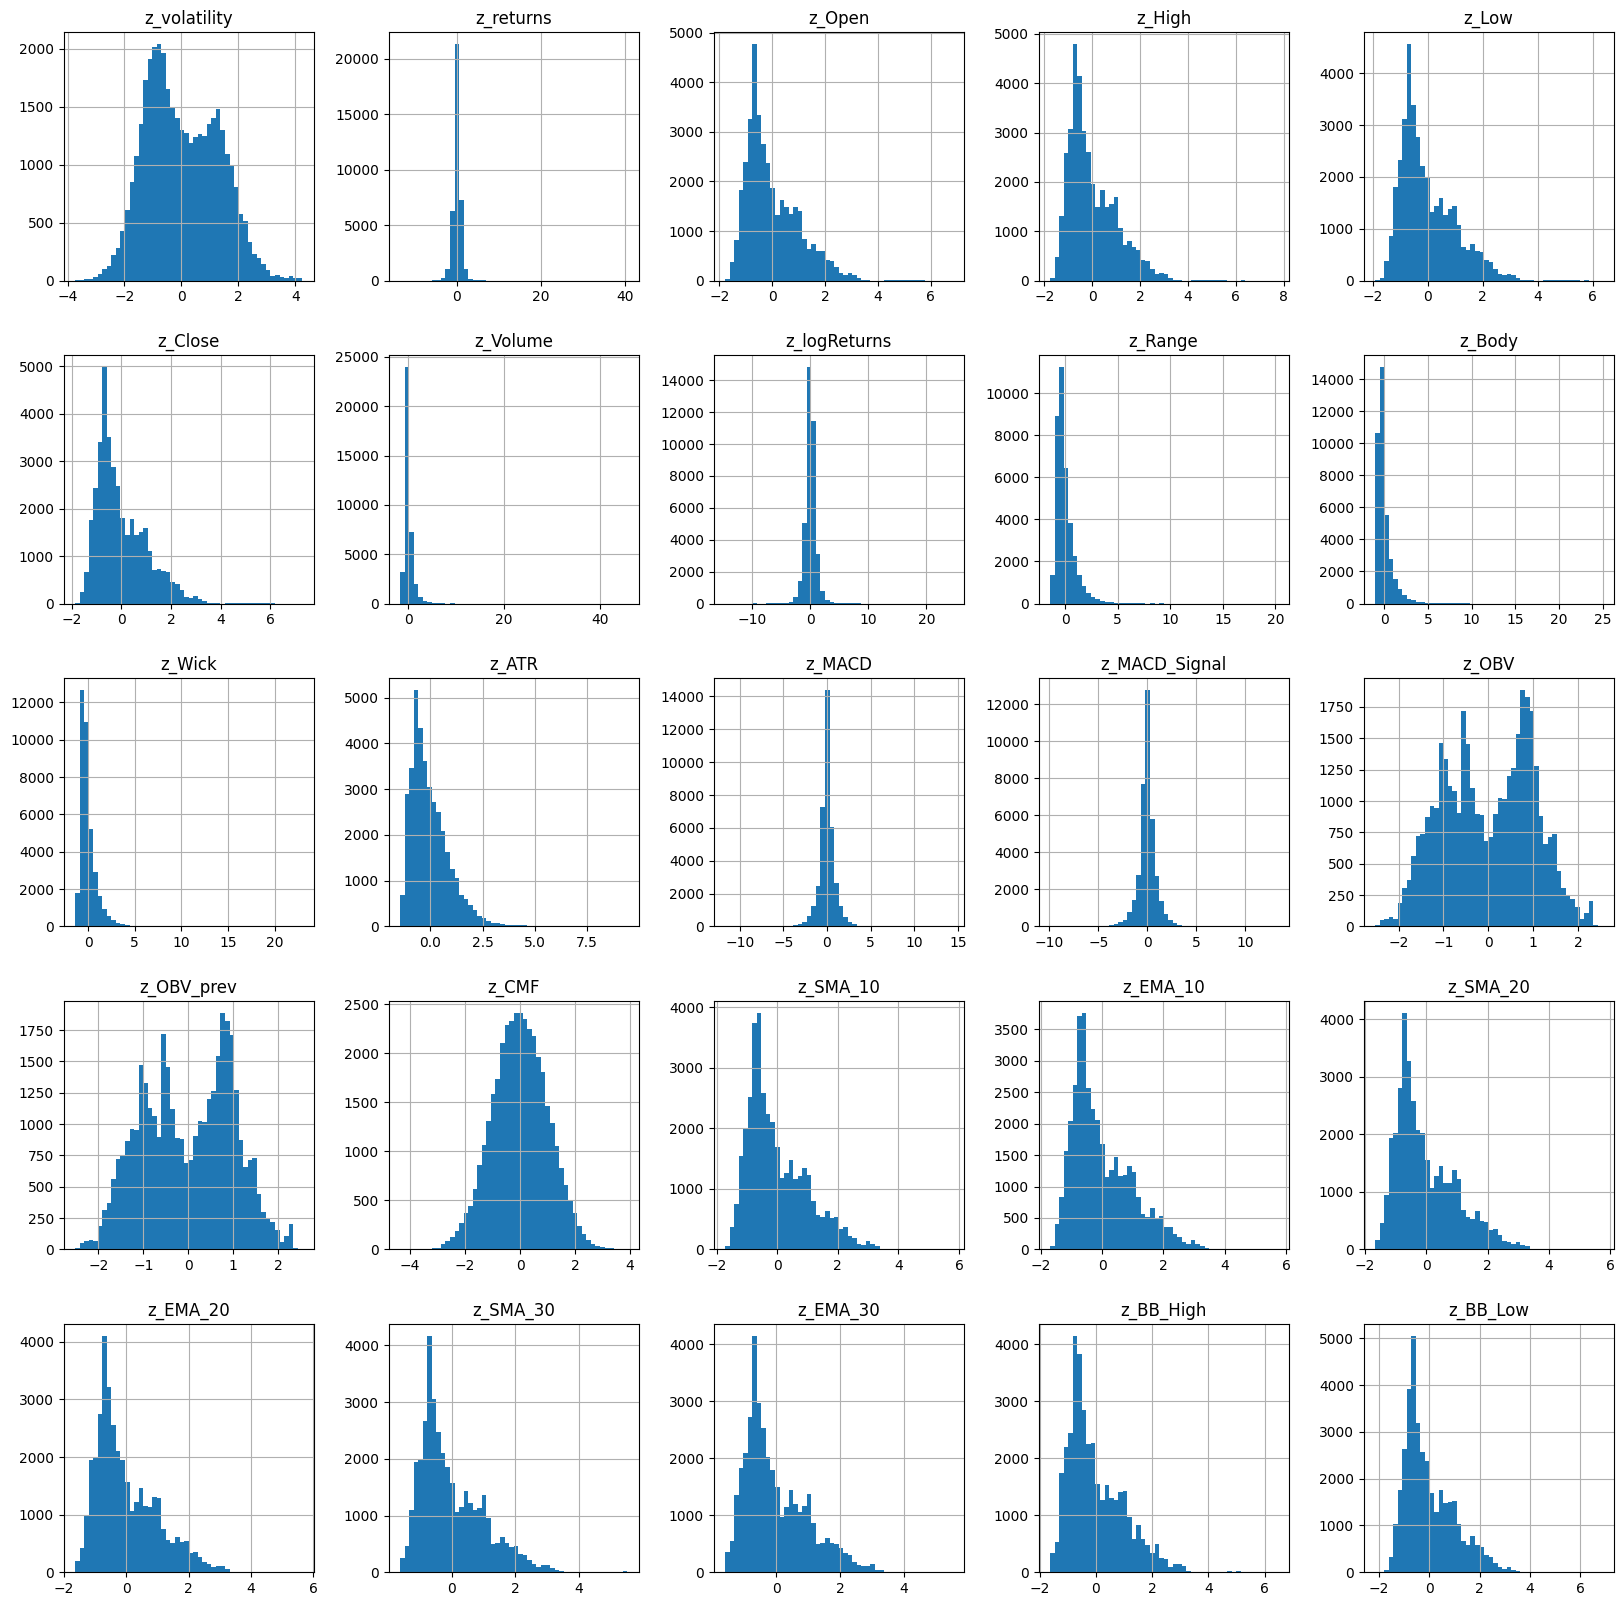

In [34]:
# Hist of normalized features
labeled_adjusted[[col for col in labeled_adjusted.columns if col.startswith('z_')]].hist(figsize=(20, 20), bins=50)


array([[<Axes: title={'center': 'z_volatility'}>,
        <Axes: title={'center': 'z_returns'}>,
        <Axes: title={'center': 'z_Open'}>,
        <Axes: title={'center': 'z_High'}>,
        <Axes: title={'center': 'z_Low'}>],
       [<Axes: title={'center': 'z_Close'}>,
        <Axes: title={'center': 'z_Volume'}>,
        <Axes: title={'center': 'z_logReturns'}>,
        <Axes: title={'center': 'z_Range'}>,
        <Axes: title={'center': 'z_Body'}>],
       [<Axes: title={'center': 'z_Wick'}>,
        <Axes: title={'center': 'z_ATR'}>,
        <Axes: title={'center': 'z_MACD'}>,
        <Axes: title={'center': 'z_MACD_Signal'}>,
        <Axes: title={'center': 'z_OBV'}>],
       [<Axes: title={'center': 'z_OBV_prev'}>,
        <Axes: title={'center': 'z_CMF'}>,
        <Axes: title={'center': 'z_SMA_10'}>,
        <Axes: title={'center': 'z_EMA_10'}>,
        <Axes: title={'center': 'z_SMA_20'}>],
       [<Axes: title={'center': 'z_EMA_20'}>,
        <Axes: title={'center': 'z_SMA

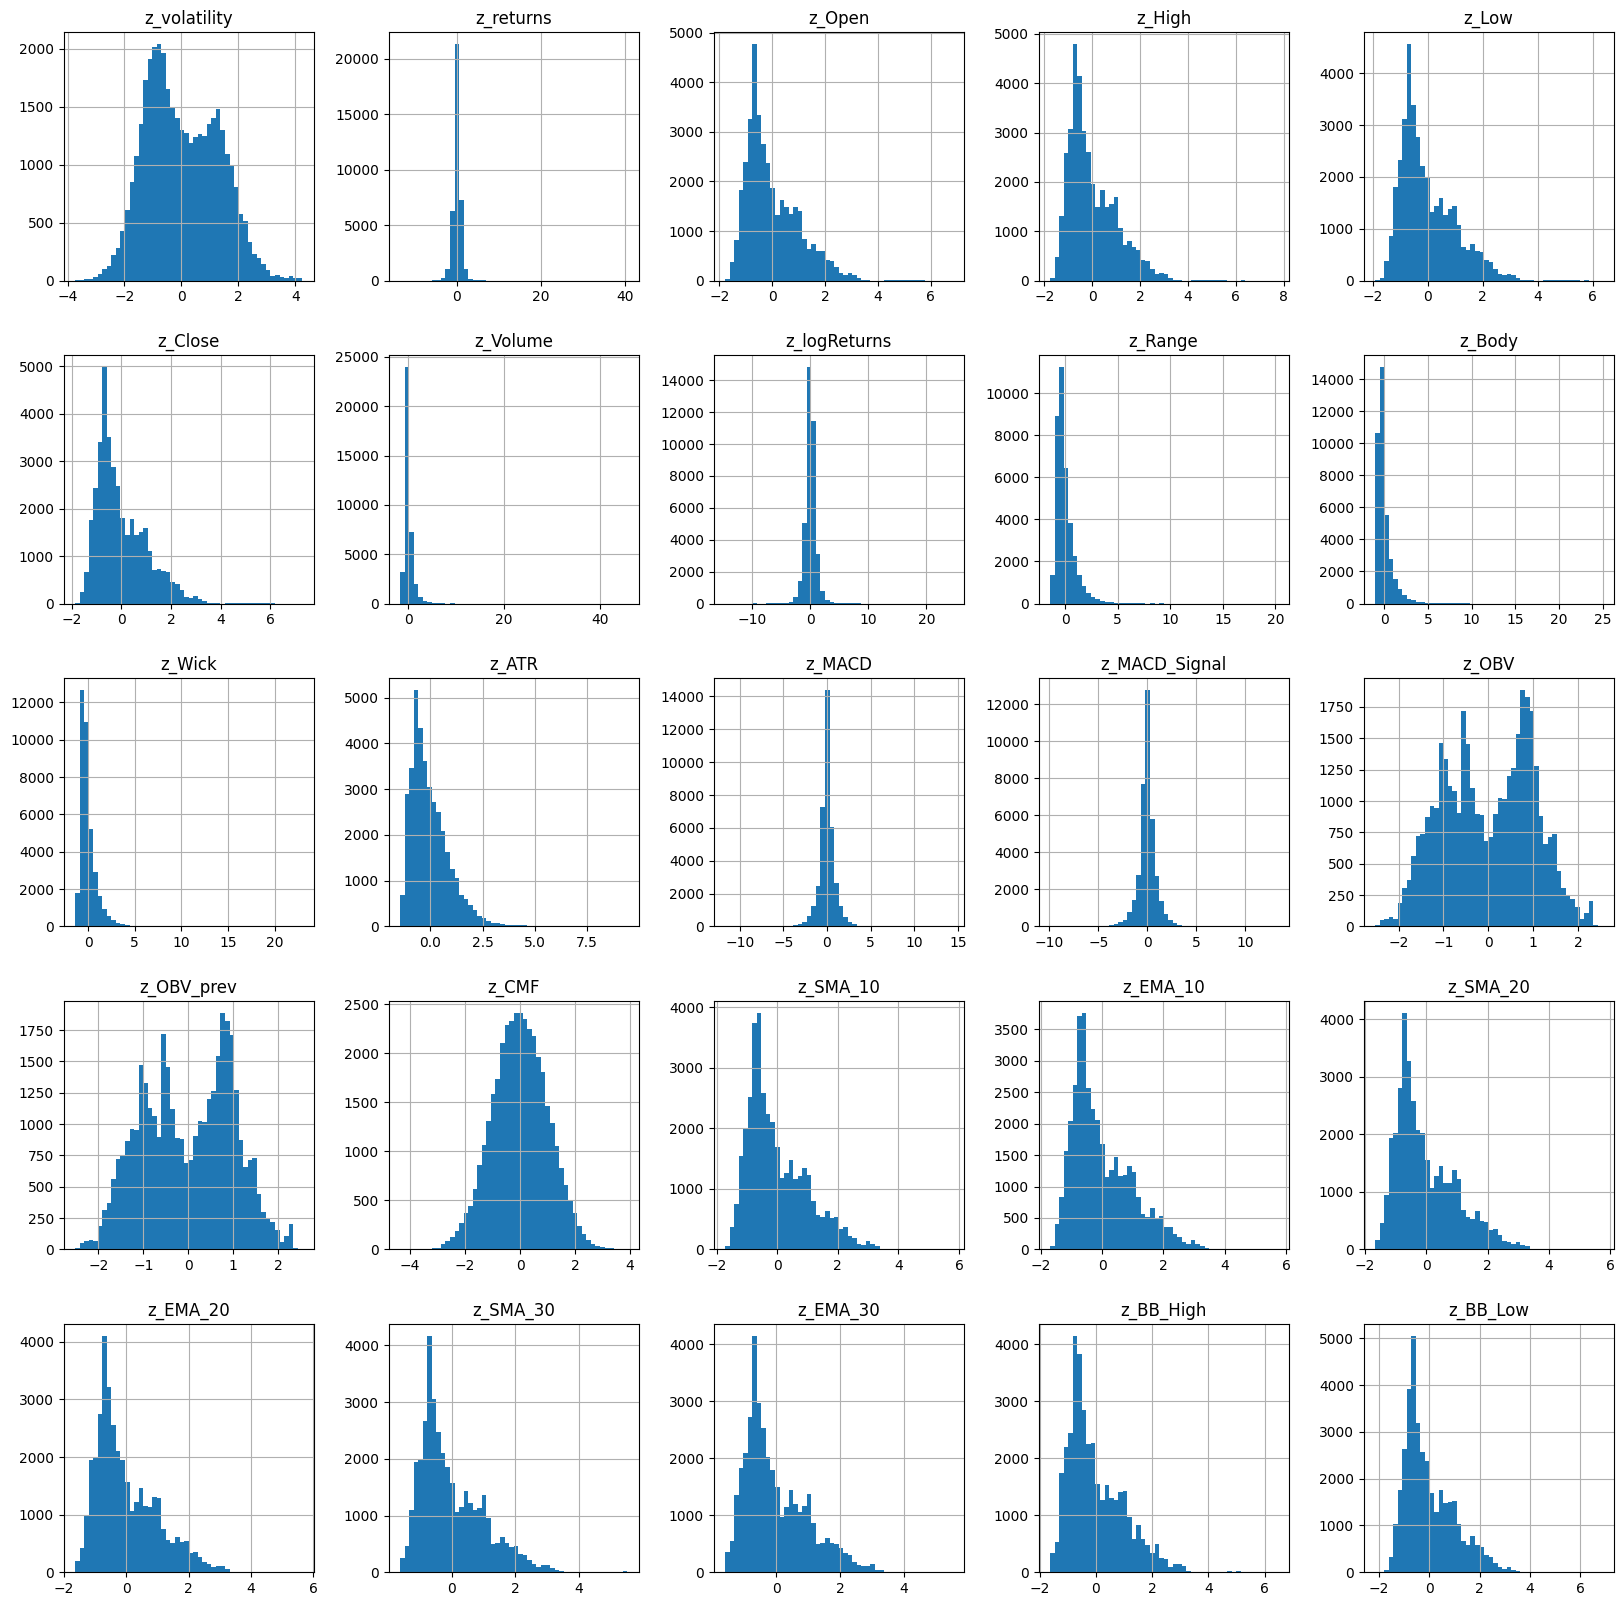

In [ ]:
# Hist of normalized features
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')]].hist(figsize=(20, 20), bins=50)

- Mean ≈ 0
- Std ≈ 1
- No extreme skew or flat distributions
- No NaNs or constant values

---

2. Verify Per-Ticker Normalization
Since we normalize per ticker, confirm that each ticker’s normalized features are centered

In [36]:
labeled_adjusted.groupby('Ticker')[[col for col in labeled_adjusted.columns if col.startswith('z_')]].mean()


Price   z_volatility  z_returns        z_Open        z_High         z_Low  \
Ticker                                                                      
AMZN        0.068149   0.001404  1.197325e-16 -6.455299e-17 -1.768575e-17   
AVGO        0.006398  -0.000417  1.591718e-17 -8.383046e-17 -2.617491e-17   
CYBR        0.051629   0.000722 -2.988892e-17  8.100074e-17 -3.537150e-17   
CYTK        0.040656  -0.004616  2.476005e-17  2.670548e-17 -2.502534e-17   
ETN         0.010283   0.001536  2.576814e-16 -2.299148e-18  5.146554e-17   
LIN         0.018304   0.000653  7.825945e-17 -2.987123e-16  8.047017e-18   
LLY         0.012923   0.001986 -3.572522e-17 -9.355762e-17  1.363571e-16   
LQD         0.026012  -0.000600  7.419173e-17  5.911462e-17 -1.680146e-18   
META        0.063012   0.000117 -8.312303e-17 -2.771357e-16 -7.958588e-18   
SLNO        0.019373   0.000853  2.697161e-17 -4.069928e-17  3.263727e-17   
SPY        -0.049008   0.001161 -5.181925e-17 -8.984362e-17 -3.070246e-16   
TLT         0.002698  -0.001746 -7.843631e-17 -1.023563e-15 -3.473482e-16   
VNQ        -0.001279  -0.000397 -1.122515e-15  8.731455e-16  1.034086e-15   
WM          0.063383  -0.000559  6.013155e-18  2.564434e-18 -4.067723e-17   
XLV        -0.015488   0.001531  5.453401e-16 -9.603363e-17  4.394909e-17   

Price        z_Close      z_Volume  z_logReturns       z_Range        z_Body  \
Ticker                                                                         
AMZN   -9.550306e-18  5.332254e-17 -5.477056e-18  4.578399e-17  1.459074e-17   
AVGO   -9.797906e-17 -7.631402e-17 -7.074300e-19 -1.768575e-17  1.520975e-17   
CYBR    3.678636e-17  7.277687e-17  6.339236e-18 -5.816401e-17  1.255688e-17   
CYTK    7.489916e-17  3.620052e-17 -5.430078e-18 -5.394154e-18 -5.482583e-17   
ETN    -1.945433e-18 -1.206168e-16 -2.539563e-17  4.244580e-18 -2.051547e-17   
LIN     7.498758e-17  2.193033e-17  1.366224e-17 -2.369891e-16  1.298576e-16   
LLY     1.715518e-17 -5.673257e-17  9.904021e-18  1.096517e-16  5.234982e-17   
LQD     5.513533e-17  7.663457e-17 -8.091231e-18  2.022255e-17  2.887199e-17   
META    4.439124e-17 -3.638843e-17  1.052302e-17  2.546748e-17  1.503289e-17   
SLNO   -7.433735e-18  2.535365e-18  9.841220e-18  3.224806e-17 -5.560011e-18   
SPY     5.889355e-17 -7.043350e-17 -1.507710e-17  5.509111e-17  1.280448e-16   
TLT    -4.297638e-16 -7.958588e-17  1.326431e-17 -9.605574e-17  8.086810e-17   
VNQ     2.440634e-16  1.570605e-16  5.681548e-18 -1.414860e-16  1.198210e-16   
WM      8.913619e-17 -1.006209e-16  7.649087e-18 -1.043459e-16 -6.402242e-17   
XLV     1.307861e-16  7.445701e-17 -1.061145e-17  1.108897e-16  6.977029e-17   

Price   ...    z_OBV_prev         z_CMF      z_SMA_10      z_EMA_10  \
Ticker  ...                                                           
AMZN    ...  1.056724e-16  1.481182e-17  1.149574e-17  1.780955e-16   
AVGO    ... -6.198856e-17 -9.727163e-18  1.025774e-16  1.520975e-17   
CYBR    ...  1.429009e-16 -8.666018e-18 -2.458319e-17 -2.253165e-16   
CYTK    ...  5.526797e-17 -7.958588e-19 -1.643891e-16 -1.360034e-16   
ETN     ... -7.215786e-17 -1.574032e-17 -5.482583e-17 -8.047017e-17   
LIN     ...  5.367625e-17 -3.125957e-17  3.652108e-17 -8.126603e-17   
LLY     ... -7.295372e-17 -4.686724e-17  6.649842e-17  5.624069e-17   
LQD     ... -6.419928e-17 -1.715518e-17 -1.167083e-15  1.024270e-15   
META    ...  9.364605e-17 -2.546748e-17  1.283986e-16 -2.405262e-17   
SLNO    ...  3.398279e-17  4.625929e-17 -6.088768e-17 -4.279541e-17   
SPY     ... -1.061145e-17 -8.993204e-17 -9.638734e-17  1.690758e-16   
TLT     ... -1.131778e-16  4.801681e-17 -4.604485e-16  1.556346e-16   
VNQ     ...  1.784934e-16  1.892375e-17 -2.158546e-16 -2.112563e-16   
WM      ... -1.566958e-16 -1.927747e-17 -4.688493e-16  2.806729e-16   
XLV     ...  1.758848e-16  3.855494e-17  9.506091e-17  2.227520e-16   

Price       z_SMA_20      z_EMA_20      z_SMA_30      z_EMA_30     z_BB_High  \
Ticker                                   

In [37]:
labeled_adjusted.groupby('Ticker')[[col for col in labeled_adjusted.columns if col.startswith('z_')]].std()


Price   z_volatility  z_returns  z_Open  z_High  z_Low  z_Close  z_Volume  \
Ticker                                                                      
AMZN        1.294935   1.002427     1.0     1.0    1.0      1.0       1.0   
AVGO        1.291861   0.999693     1.0     1.0    1.0      1.0       1.0   
CYBR        1.269781   0.998284     1.0     1.0    1.0      1.0       1.0   
CYTK        1.279942   0.997356     1.0     1.0    1.0      1.0       1.0   
ETN         1.266377   1.001310     1.0     1.0    1.0      1.0       1.0   
LIN         1.253334   1.001677     1.0     1.0    1.0      1.0       1.0   
LLY         1.298355   1.001912     1.0     1.0    1.0      1.0       1.0   
LQD         1.232916   1.003494     1.0     1.0    1.0      1.0       1.0   
META        1.270190   1.003036     1.0     1.0    1.0      1.0       1.0   
SLNO        1.259533   1.003544     1.0     1.0    1.0      1.0       1.0   
SPY         1.306965   1.001075     1.0     1.0    1.0      1.0       1.0   
TLT         1.214533   1.000601     1.0     1.0    1.0      1.0       1.0   
VNQ         1.266183   1.002690     1.0     1.0    1.0      1.0       1.0   
WM          1.283586   1.002764     1.0     1.0    1.0      1.0       1.0   
XLV         1.265013   0.999460     1.0     1.0    1.0      1.0       1.0   

Price   z_logReturns  z_Range  z_Body  ...  z_OBV_prev  z_CMF  z_SMA_10  \
Ticker                                 ...                                
AMZN             1.0      1.0     1.0  ...         1.0    1.0       1.0   
AVGO             1.0      1.0     1.0  ...         1.0    1.0       1.0   
CYBR             1.0      1.0     1.0  ...         1.0    1.0       1.0   
CYTK             1.0      1.0     1.0  ...         1.0    1.0       1.0   
ETN              1.0      1.0     1.0  ...         1.0    1.0       1.0   
LIN              1.0      1.0     1.0  ...         1.0    1.0       1.0   
LLY              1.0      1.0     1.0  ...         1.0    1.0       1.0   
LQD              1.0      1.0     1.0  ...         1.0    1.0       1.0   
META             1.0      1.0     1.0  ...         1.0    1.0       1.0   
SLNO             1.0      1.0     1.0  ...         1.0    1.0       1.0   
SPY              1.0      1.0     1.0  ...         1.0    1.0       1.0   
TLT              1.0      1.0     1.0  ...         1.0    1.0       1.0   
VNQ              1.0      1.0     1.0  ...         1.0    1.0       1.0   
WM               1.0      1.0     1.0  ...         1.0    1.0       1.0   
XLV              1.0      1.0     1.0  ...         1.0    1.0       1.0   

Price   z_EMA_10  z_SMA_20  z_EMA_20  z_SMA_30  z_EMA_30  z_BB_High  z_BB_Low  
Ticker                                                                         
AMZN         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
AVGO         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
CYBR         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
CYTK         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
ETN          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
LIN          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
LLY          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
LQD          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
META         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
SLNO         1.0       1.0       1.0       1.0       1.0        1.0       1.0  
SPY          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
TLT          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
VNQ          1.0       1.0       1.0       1.0       1.0        1.0       1.0  
WM           1.0       1.0       1.0       1.0       1.0        1.0       1.0  
XLV          1.0       1.0       1.0       1.0       1.0        1.0       1.0  

[15 rows x 25 columns]

In [38]:
labeled_adjusted[[col for col in labeled_adjusted.columns if col.startswith('z_')] + ['future_return']].corr()['future_return'].sort_values(ascending=False)

Price
future_return    1.000000
z_volatility     0.016640
z_OBV_prev       0.008201
z_OBV            0.007798
z_Volume         0.004804
z_ATR           -0.000546
z_Body          -0.001665
z_Range         -0.003406
z_Wick          -0.003620
z_returns       -0.010414
z_CMF           -0.011156
z_logReturns    -0.011625
z_BB_High       -0.018202
z_MACD_Signal   -0.020087
z_MACD          -0.020116
z_SMA_30        -0.020143
z_EMA_30        -0.020210
z_SMA_20        -0.020934
z_EMA_20        -0.021183
z_EMA_10        -0.022038
z_SMA_10        -0.022071
z_High          -0.022131
z_Open          -0.022485
z_Close         -0.022860
z_Low           -0.023000
z_BB_Low        -0.023794
Name: future_return, dtype: float64

In [39]:
labeled_realistic[[col for col in labeled_realistic.columns if col.startswith('z_')] + ['future_return']].corr()['future_return'].sort_values(ascending=False)

Price
future_return    1.000000
z_volatility     0.016640
z_OBV_prev       0.008201
z_OBV            0.007798
z_Volume         0.004804
z_ATR           -0.000546
z_Body          -0.001665
z_Range         -0.003406
z_Wick          -0.003620
z_returns       -0.010414
z_CMF           -0.011156
z_logReturns    -0.011625
z_BB_High       -0.018202
z_MACD_Signal   -0.020087
z_MACD          -0.020116
z_SMA_30        -0.020143
z_EMA_30        -0.020210
z_SMA_20        -0.020934
z_EMA_20        -0.021183
z_EMA_10        -0.022038
z_SMA_10        -0.022071
z_High          -0.022131
z_Open          -0.022485
z_Close         -0.022860
z_Low           -0.023000
z_BB_Low        -0.023794
Name: future_return, dtype: float64

<Axes: xlabel='z_MACD', ylabel='future_return'>

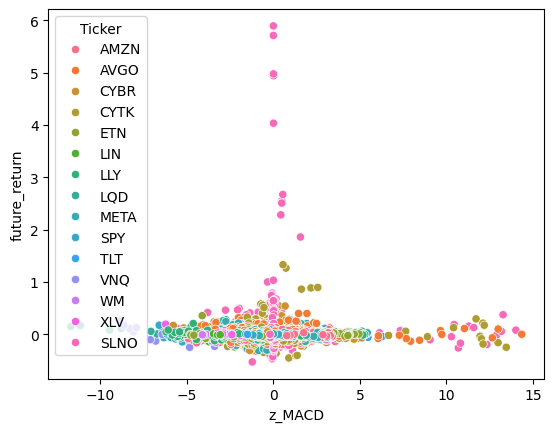

In [40]:
sns.scatterplot(data=labeled_adjusted, x='z_MACD', y='future_return', hue='Ticker')


In [41]:
# No NaNS and 
labeled_adjusted[[col for col in labeled_adjusted.columns if col.startswith('z_')]].isna().mean().sort_values()

Price
z_volatility     0.0
z_returns        0.0
z_Open           0.0
z_High           0.0
z_Low            0.0
z_Close          0.0
z_Volume         0.0
z_logReturns     0.0
z_Range          0.0
z_Body           0.0
z_Wick           0.0
z_ATR            0.0
z_MACD           0.0
z_MACD_Signal    0.0
z_OBV            0.0
z_OBV_prev       0.0
z_CMF            0.0
z_SMA_10         0.0
z_EMA_10         0.0
z_SMA_20         0.0
z_EMA_20         0.0
z_SMA_30         0.0
z_EMA_30         0.0
z_BB_High        0.0
z_BB_Low         0.0
dtype: float64

In [42]:
# Enough unique values
labeled_adjusted[[col for col in labeled_adjusted.columns if col.startswith('z_')]].nunique().sort_values()

Price
z_Body           31953
z_Wick           33028
z_Range          33217
z_Close          34393
z_Open           35062
z_Low            35236
z_High           35285
z_Volume         36100
z_returns        37114
z_logReturns     37114
z_SMA_10         37435
z_SMA_20         37544
z_SMA_30         37560
z_BB_High        37601
z_BB_Low         37601
z_OBV            37621
z_OBV_prev       37621
z_MACD_Signal    37650
z_ATR            37650
z_volatility     37650
z_MACD           37650
z_EMA_10         37650
z_EMA_20         37650
z_CMF            37650
z_EMA_30         37650
dtype: int64

In [49]:
amzn = labeled_adjusted.groupby(labeled_adjusted.index.get_level_values('Ticker')).get_group('AMZN')
print(amzn[['MACD', 'z_MACD']].dropna().head())


Price                  MACD    z_MACD
Date       Ticker                    
2015-01-02 AMZN    0.027614 -0.148219
2015-01-05 AMZN   -0.022347 -0.176591
2015-01-06 AMZN   -0.101310 -0.221431
2015-01-07 AMZN   -0.123162 -0.233840
2015-01-08 AMZN   -0.116942 -0.230308


<Axes: title={'center': 'Raw vs Normalized MACD'}>

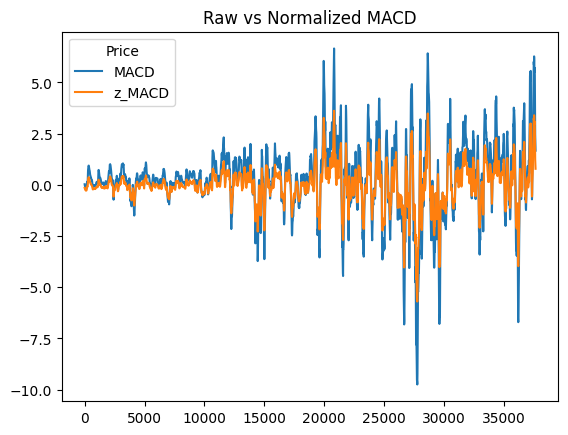

In [50]:
df_reset = labeled_adjusted.reset_index()
df_reset[df_reset['Ticker'] == 'AMZN'][['MACD', 'z_MACD']].plot(title='Raw vs Normalized MACD')


In [69]:
def show_correlation(df, tickers):
    print("Tickers to proecess", tickers)
    for ticker in tickers:
        try:
            group = df.groupby(df.index.get_level_values('Ticker')).get_group(ticker)
            corr = group[['MACD', 'z_MACD']].corr().iloc[0, 1]
            print(f"Correlation between {ticker} MACD and z_MACD: {corr:.4f}")
        except KeyError:
            print(f"{ticker} not found in DataFrame.")
        except Exception as e:
            print(f"Error processing {ticker}: {e}")



In [71]:
show_correlation(labeled_adjusted, tickers)

Tickers to proecess ['AMZN', 'META', 'AVGO', 'LLY', 'ETN', 'CYBR', 'LIN', 'WM', 'SLNO', 'CYTK', 'SPY', 'TLT', 'LQD', 'VNQ', 'XLV']
Correlation between AMZN MACD and z_MACD: 1.0000
Correlation between META MACD and z_MACD: 1.0000
Correlation between AVGO MACD and z_MACD: 1.0000
Correlation between LLY MACD and z_MACD: 1.0000
Correlation between ETN MACD and z_MACD: 1.0000
Correlation between CYBR MACD and z_MACD: 1.0000
Correlation between LIN MACD and z_MACD: 1.0000
Correlation between WM MACD and z_MACD: 1.0000
Correlation between SLNO MACD and z_MACD: 1.0000
Correlation between CYTK MACD and z_MACD: 1.0000
Correlation between SPY MACD and z_MACD: 1.0000
Correlation between TLT MACD and z_MACD: 1.0000
Correlation between LQD MACD and z_MACD: 1.0000
Correlation between VNQ MACD and z_MACD: 1.0000
Correlation between XLV MACD and z_MACD: 1.0000


In [72]:
show_correlation(labeled_realistic, tickers)

Tickers to proecess ['AMZN', 'META', 'AVGO', 'LLY', 'ETN', 'CYBR', 'LIN', 'WM', 'SLNO', 'CYTK', 'SPY', 'TLT', 'LQD', 'VNQ', 'XLV']
Correlation between AMZN MACD and z_MACD: 1.0000
Correlation between META MACD and z_MACD: 1.0000
Correlation between AVGO MACD and z_MACD: 1.0000
Correlation between LLY MACD and z_MACD: 1.0000
Correlation between ETN MACD and z_MACD: 1.0000
Correlation between CYBR MACD and z_MACD: 1.0000
Correlation between LIN MACD and z_MACD: 1.0000
Correlation between WM MACD and z_MACD: 1.0000
Correlation between SLNO MACD and z_MACD: 1.0000
Correlation between CYTK MACD and z_MACD: 1.0000
Correlation between SPY MACD and z_MACD: 1.0000
Correlation between TLT MACD and z_MACD: 1.0000
Correlation between LQD MACD and z_MACD: 1.0000
Correlation between VNQ MACD and z_MACD: 1.0000
Correlation between XLV MACD and z_MACD: 1.0000


In [53]:
def plot_all_tickers(df):
    df_reset = df.reset_index()
    n = len(tickers)

    # Create subplots grid
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 4 * n), sharex=True)

    # If only one ticker, axes won't be iterable
    if n == 1:
        axes = [axes]

    # Loop through tickers and plot on individual axes
    for i, ticker in enumerate(tickers):
        df_t = df_reset[df_reset['Ticker'] == ticker].dropna(subset=['MACD', 'z_MACD'])
        axes[i].plot(df_t['Date'], df_t['MACD'], label='MACD')
        axes[i].plot(df_t['Date'], df_t['z_MACD'], label='z_MACD')
        axes[i].set_title(f"{ticker} – Raw vs Normalized MACD")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


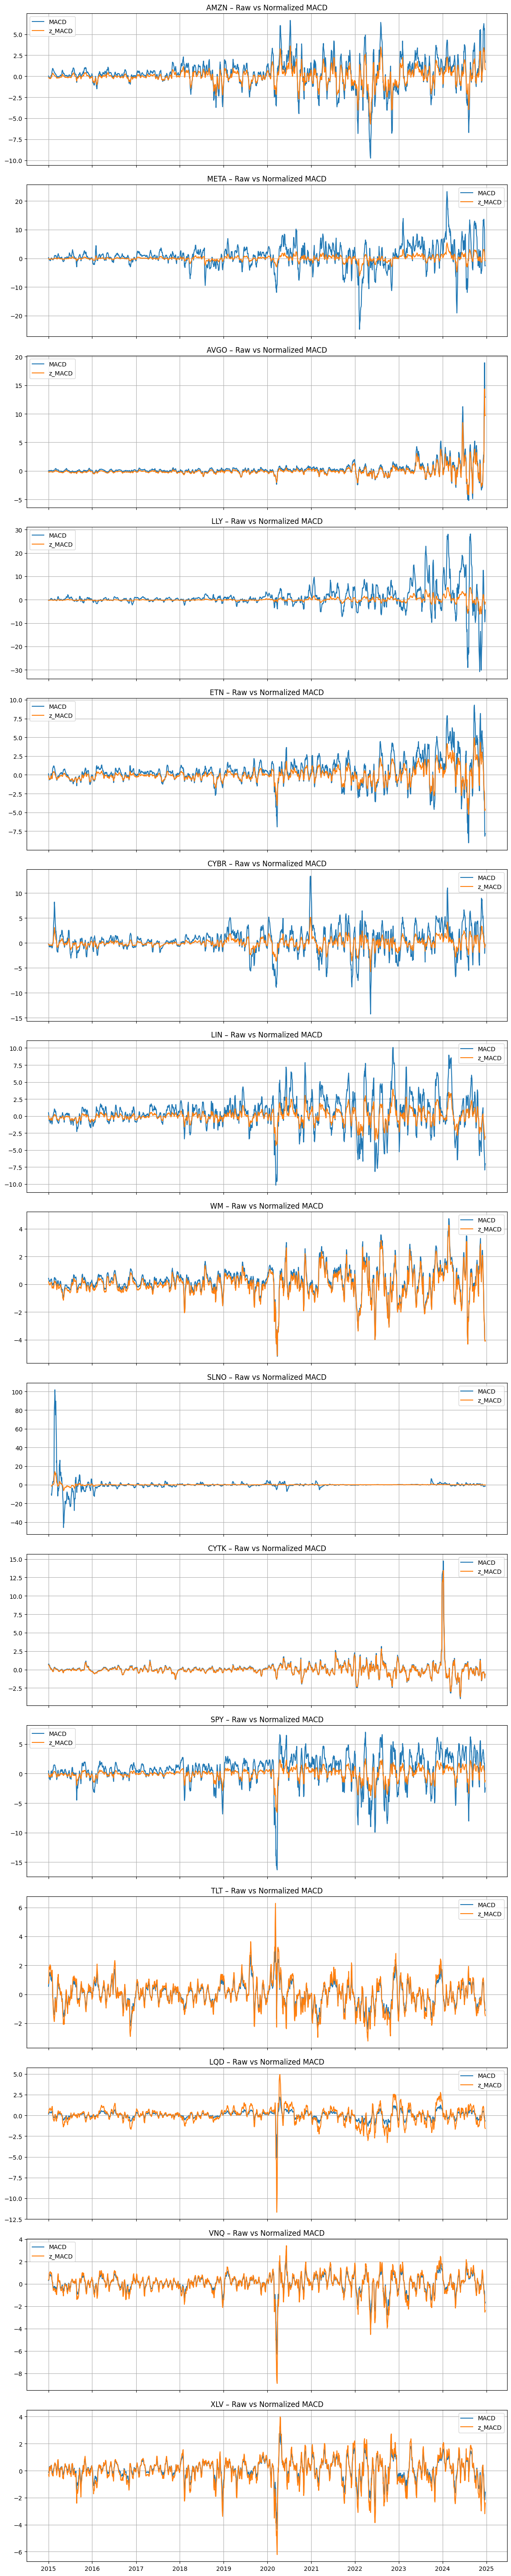

In [54]:
plot_all_tickers(labeled_adjusted)

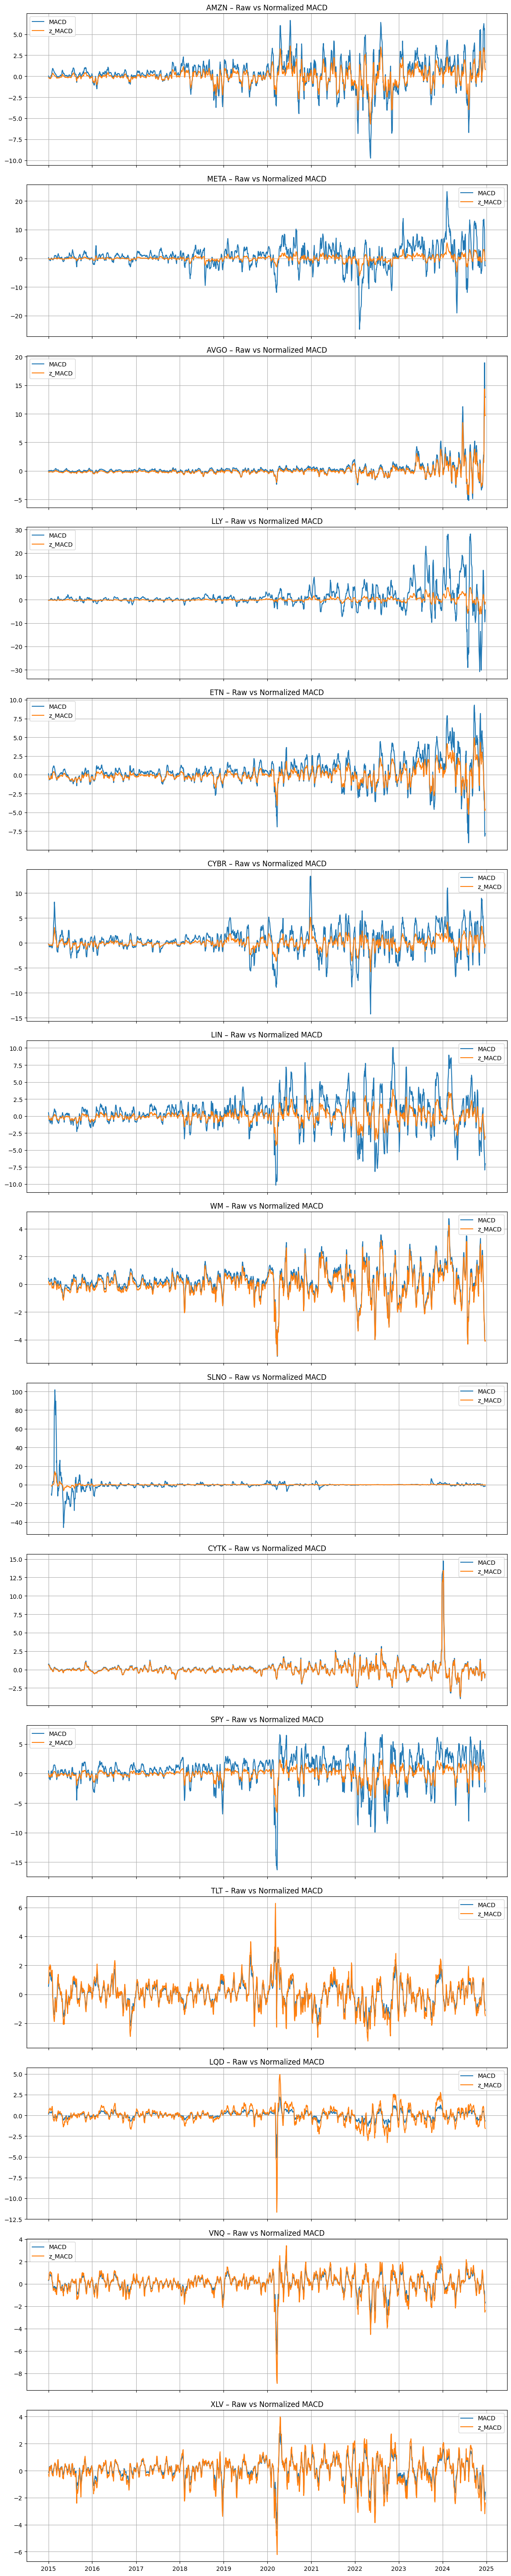

In [55]:
plot_all_tickers(labeled_realistic)

In [80]:
def across_indicator_signal_response(df, target_ticker='AMZN'):
    df_reset = df.reset_index()
    df_reset['Ticker'] = df_reset['Ticker'].str.lower()
    target_ticker = target_ticker.lower()

    raw_vs_z_pairs = []
    for z_col in df.columns:
        if z_col.startswith('z_'):
            raw_candidate = z_col.replace('z_', '')
            # Find actual column name that matches case-insensitively
            raw_match = next((col for col in df.columns if col.lower() == raw_candidate.lower()), None)
            if raw_match:
                raw_vs_z_pairs.append((raw_match, z_col))


    for raw, z in raw_vs_z_pairs:
        df_t = df_reset[df_reset['Ticker'] == target_ticker].dropna(subset=[raw, z])
        if df_t.empty:
            continue
        df_t[[raw, z]].plot(title=f"{raw} vs {z} – {target_ticker.upper()}", figsize=(10, 4))
        plt.grid(True)
        plt.tight_layout()
        plt.show()



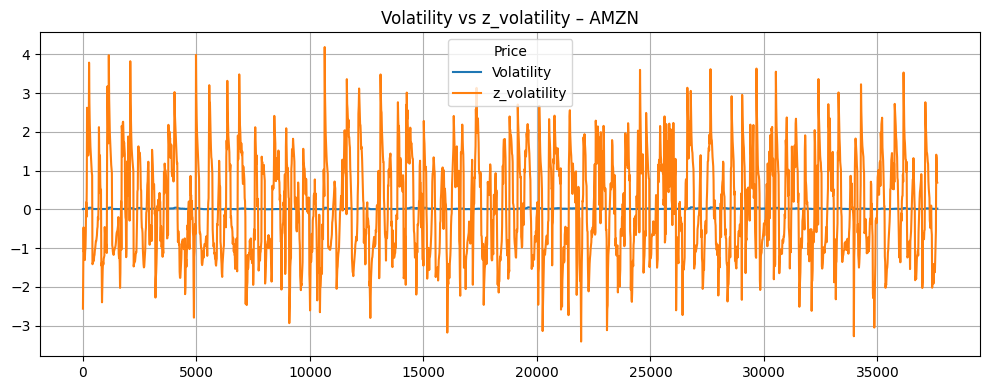

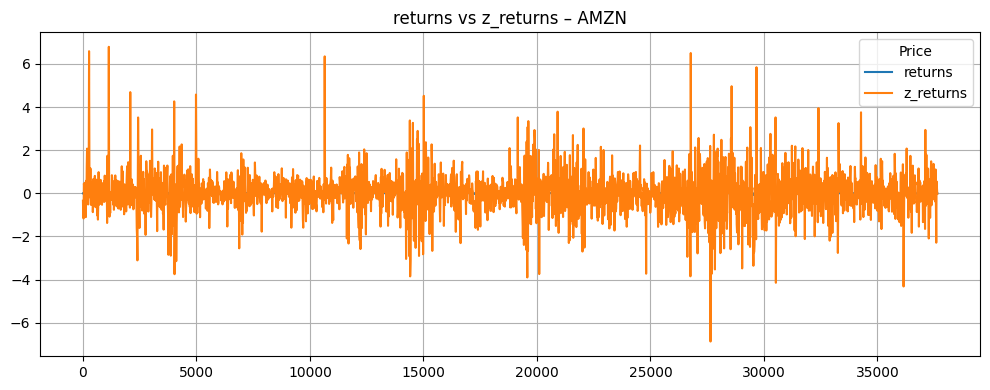

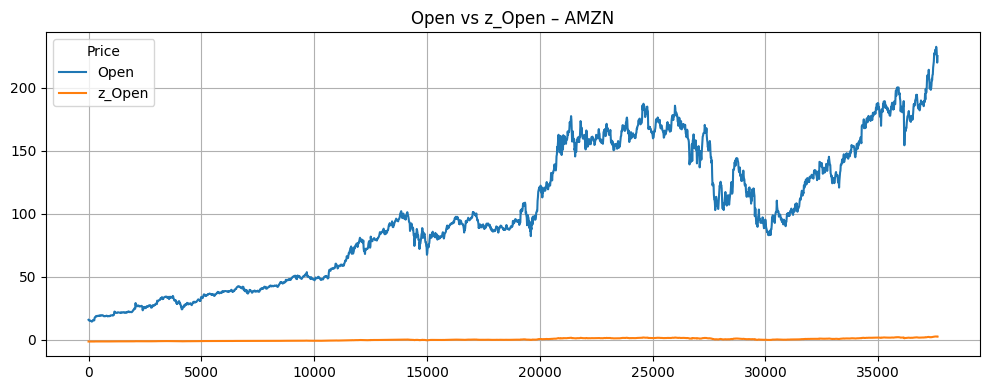

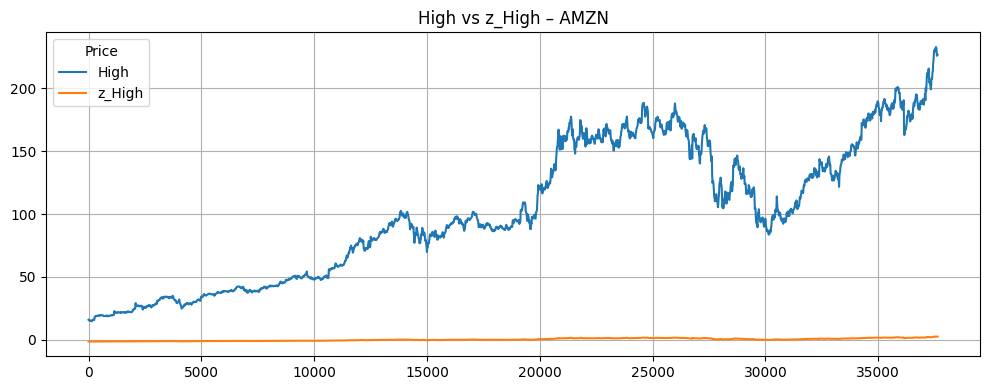

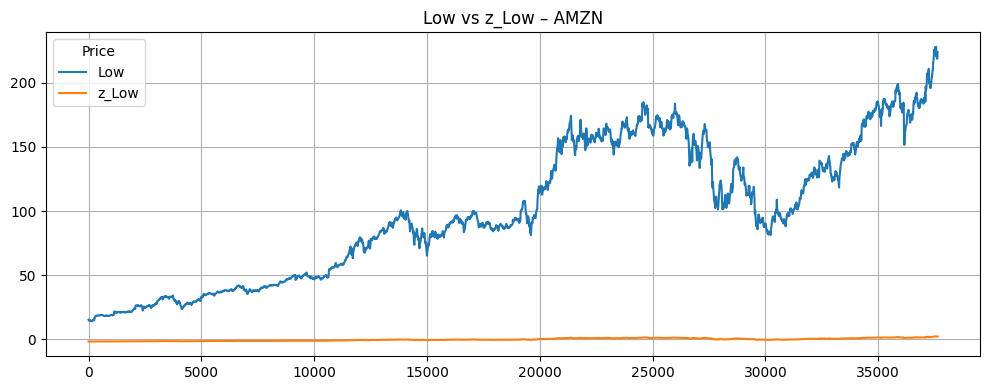

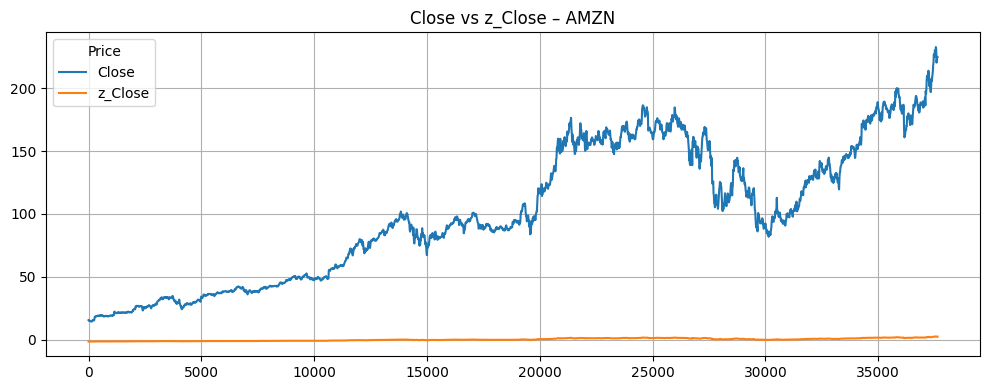

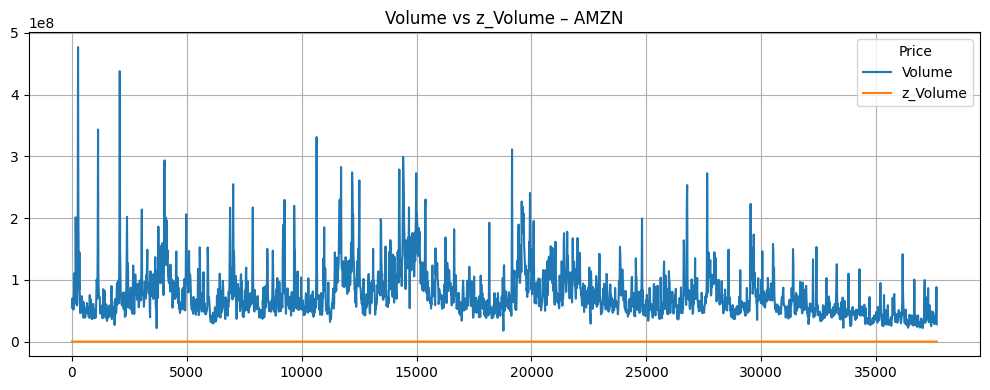

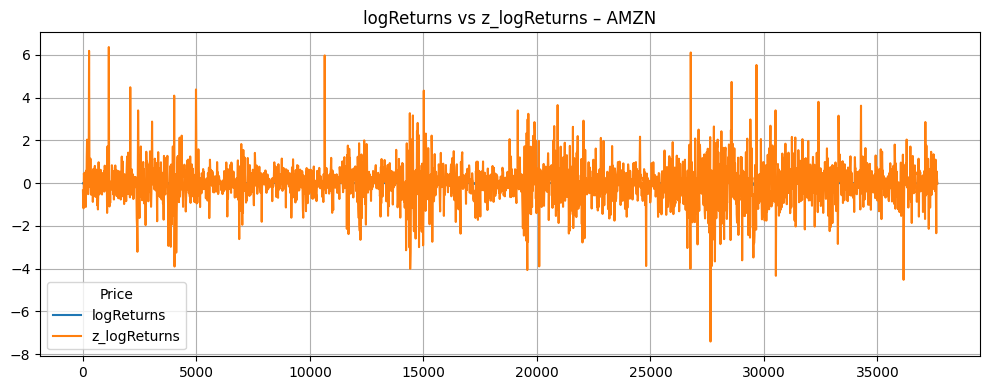

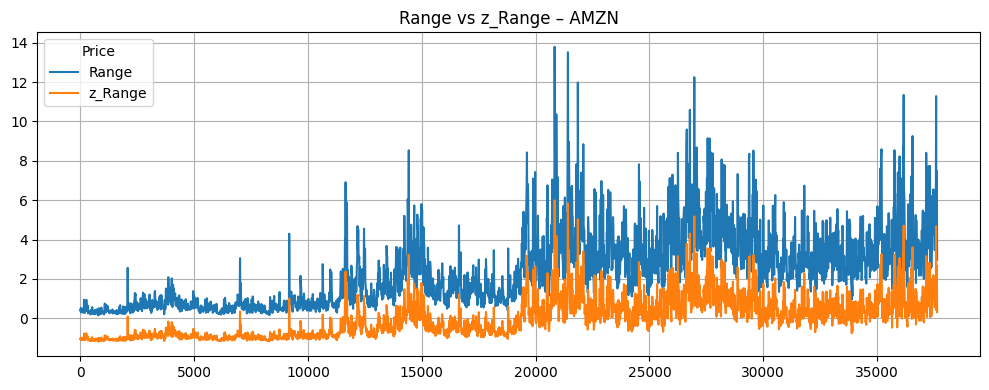

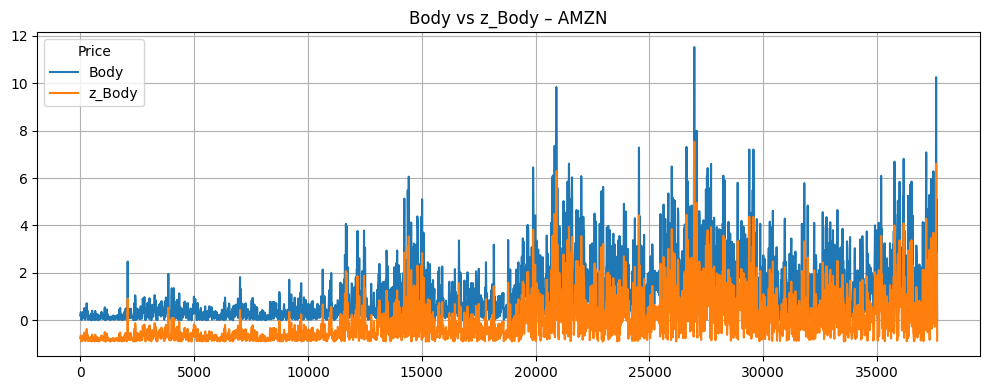

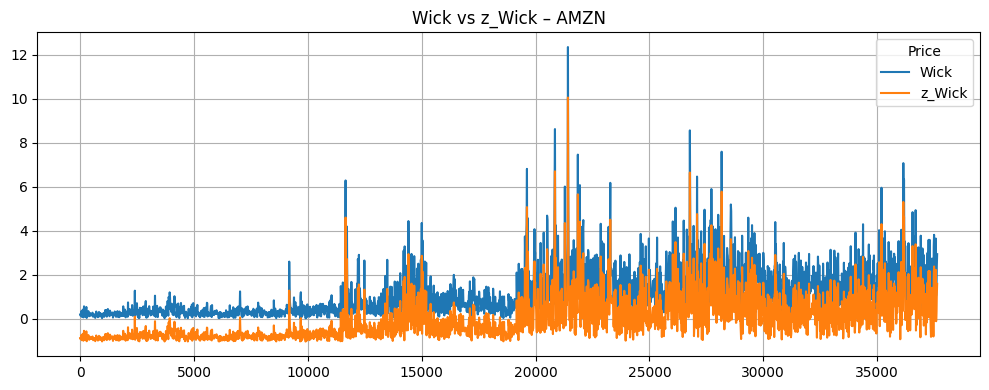

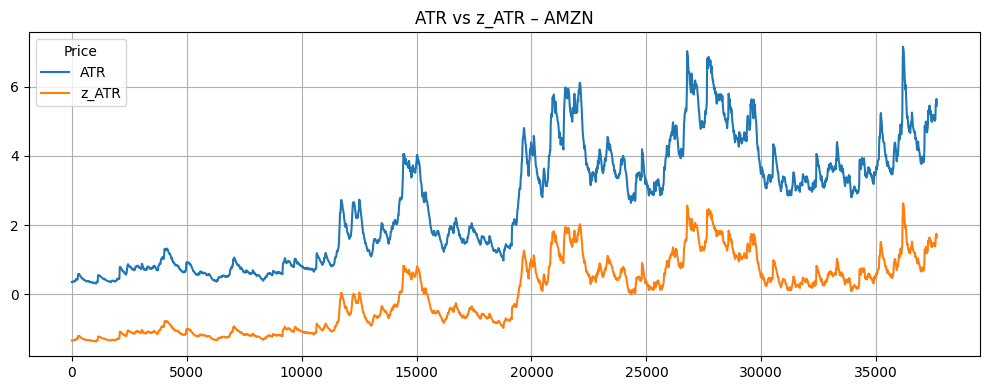

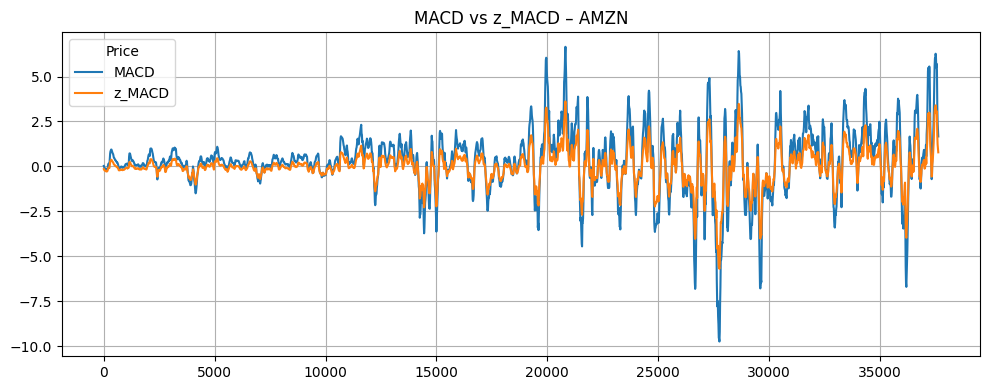

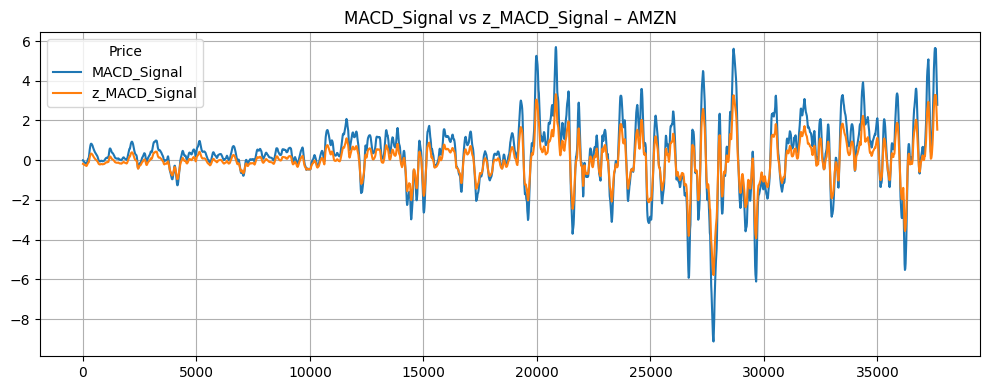

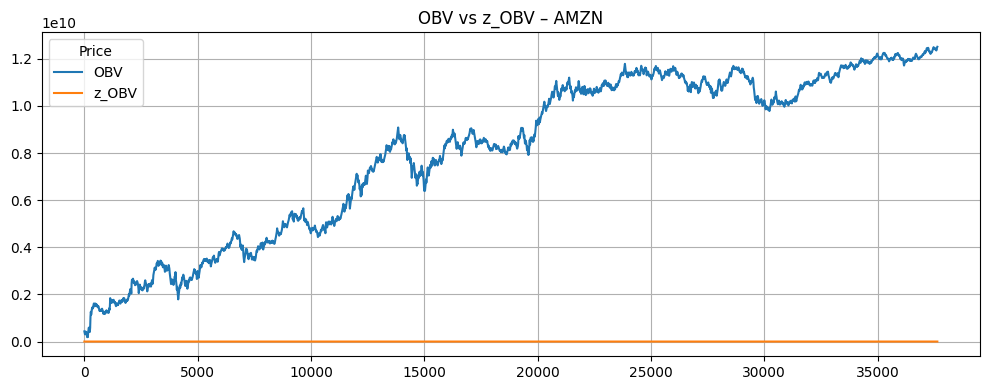

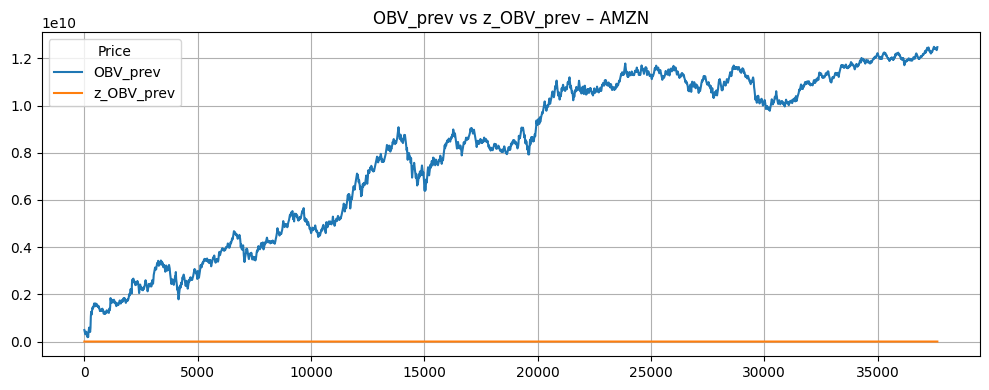

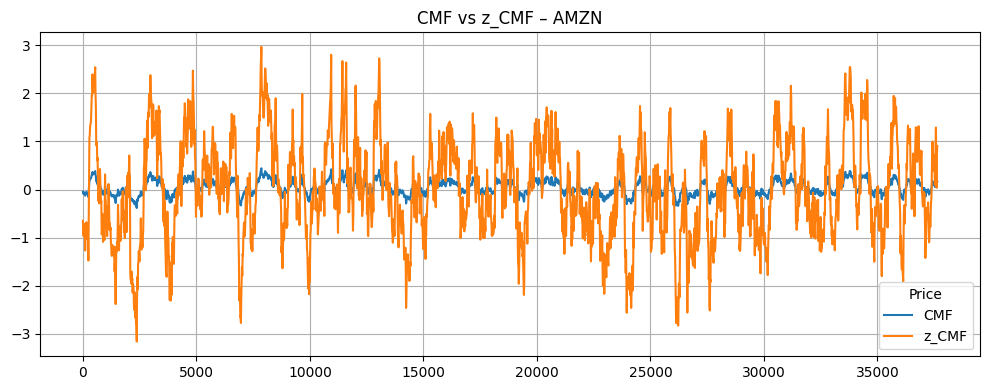

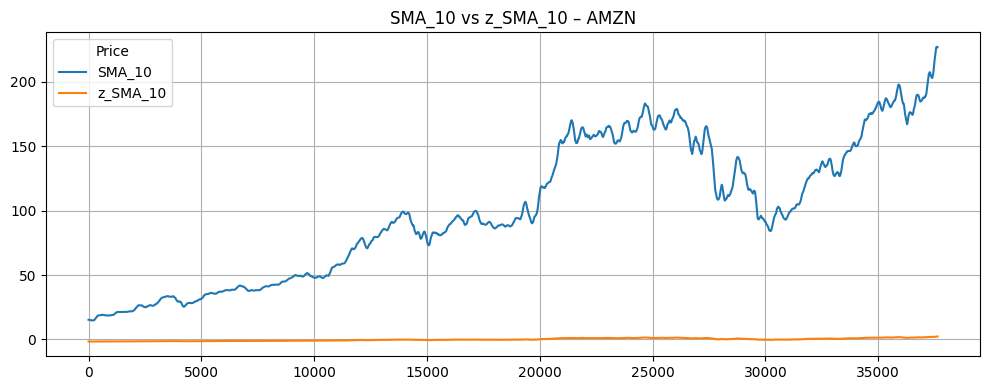

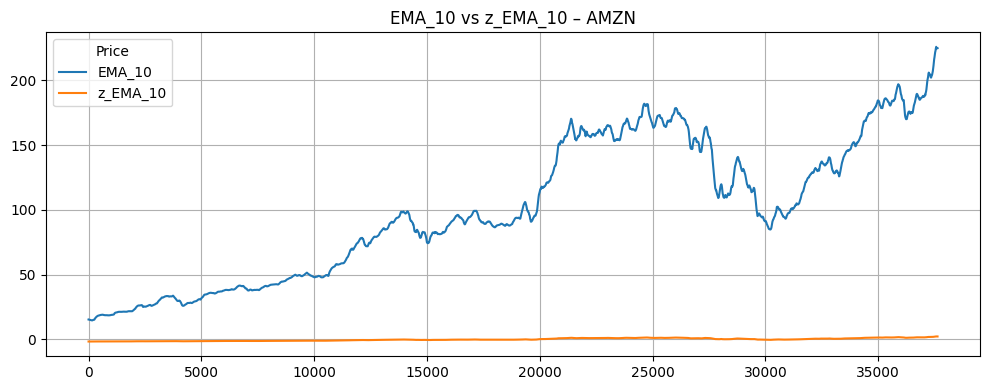

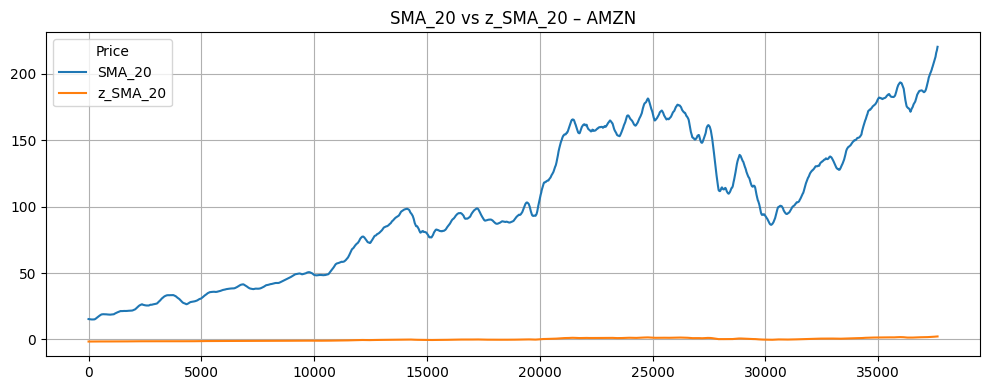

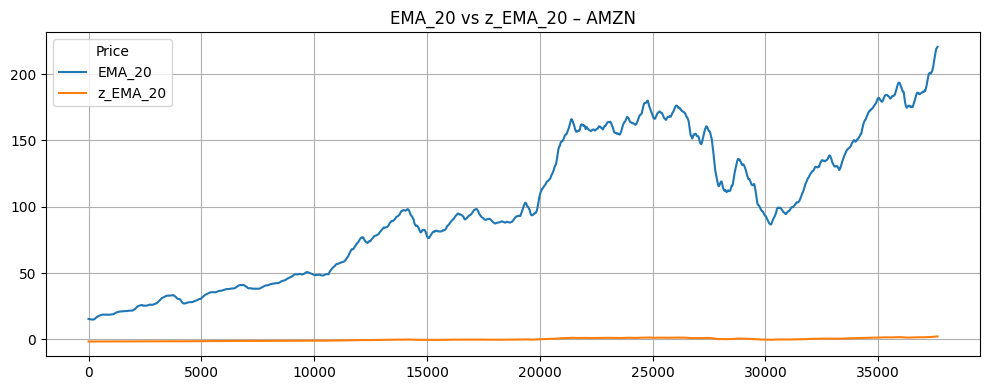

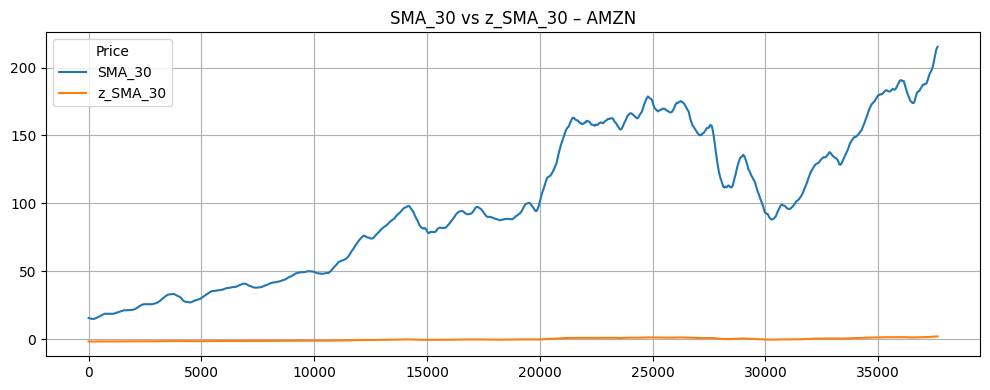

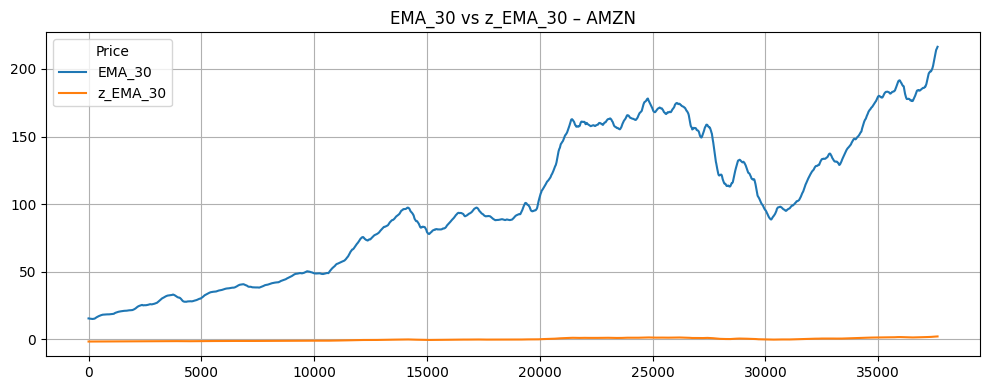

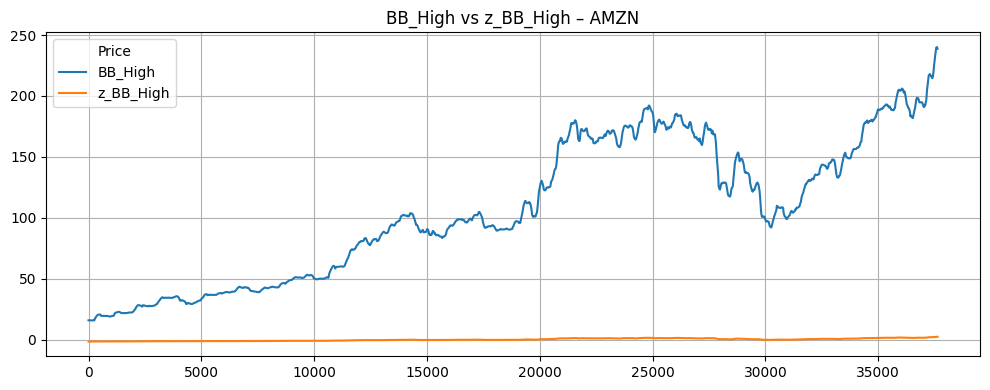

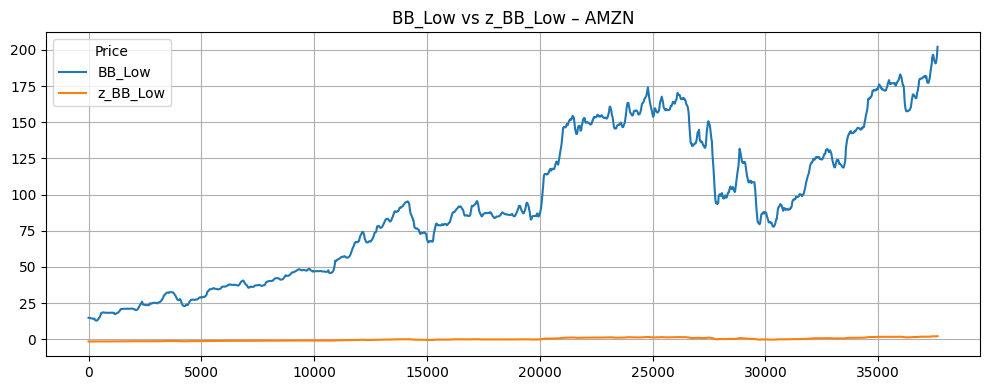

In [81]:
across_indicator_signal_response(labeled_adjusted)